In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys


from scipy.stats import pearsonr


# sklearn ML models
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import  LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold

import joblib

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'


/Users/liugrp_m/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# exp HOMO-LUMO gap

In [2]:
df=pd.read_csv('../01-database-preprocessing-1203dp-to-1115dp/raw/atom_number_wH_sort_1115-backbone-correction-newSMILES.csv')
df

Nickname  bandgap(eV)  \
0                    P3HT         1.93   
1                   P3HST         1.82   
2                    POPT         1.76   
3                   PT-C1         1.92   
4                   PT-C2         1.89   
...                   ...          ...   
1110              BTT-NTz         1.68   
1111             PIDTI-BT         1.65   
1112           PIDTI-DTBT         1.66   
1113  poly(DPP4T-alt-TBP)         1.52   
1114         PIDTBDT(ID)2         1.73   

                                               c_smiles  \
0                                     CCCCCCc1cc(C)sc1C   
1                                    CCCCCCSc1cc(C)sc1C   
2                        CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1   
3                 CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1   
4       CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1   
...                                                 ...   
1110  CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...   
1111  CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...   
1112  CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...   
1113  CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...   
1114  CCCCCCCCCCC(CCCCCCCC)CN1C(=O)/C(=C2/C(=O)N(CC(...   

                                              newSMILES Ref.No  
0     Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...    S10  
1     CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...   S123  
2     Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...   S126  
3     COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...   S122  
4     COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...   S122  
...                                                 ...    ...  
1110  Cc1cc(C)c(s1)-c1cc2c3sc(C)cc3c3cc(sc3c2s1)-c1s...   S115  
1111  Cc1cc2n(C)c3cc4-c5cc6c(cc5C(c4cc3c2s1)(c1ccccc...   S441  
1112  Cc1ccc(s1)-c1ccc(-c2ccc(s2)-c2cc3n(C)c4cc5-c6c...   S441  
1113  CN1C(=O)C2=C(N(C)C(=O)C2=C1c1ccc(C)s1)c1ccc(s1...   S464  
1114  Cc1cc2c(s1)-c1cc3c(cc1C2(c1ccccc1)c1ccccc1)-c1...   S423  

[1115 rows x 5 columns]

In [3]:
df_exp = df['bandgap(eV)']
df_exp

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1110    1.68
1111    1.65
1112    1.66
1113    1.52
1114    1.73
Name: bandgap(eV), Length: 1115, dtype: float64

# Read RDKit-209 features

In [4]:
rdkit_feature = pd.read_csv('monomer-1115dp-RDKit209.csv')
rdkit_feature

features = pd.read_csv('rdkit_feature_list.csv')
rdkit_feature_list = features.columns
rdkit_feature_list

df_rdkit_screen = rdkit_feature[rdkit_feature_list]
df_rdkit_screen

MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed  \
0              2.353121           1.287870        1.287870  0.608740   
1              2.323896           1.288704        1.288704  0.485488   
2              2.313310           1.230210        1.230210  0.463323   
3             12.542211           0.175600       -0.175600  0.510163   
4             12.817589           0.184059       -0.184059  0.318494   
...                 ...                ...             ...       ...   
1110           5.448759           0.613257        0.613257  0.035659   
1111           6.964899           0.506884       -0.861916  0.035381   
1112           7.004105           0.497358       -0.874785  0.035381   
1113          17.056452           0.015571        0.015571  0.035580   
1114          16.708810           0.005321       -0.735237  0.028094   

         MolWt  MaxPartialCharge  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MRLOW  \
0      196.359          0.004899          1.153846    32.133559      0.666334   
1      228.426          0.021102          1.214286    32.166789      0.706317   
2      300.511          0.009536          0.857143    32.133560      0.607357   
3      350.549          0.339170          1.173913    32.136388      0.042938   
4      432.676          0.339170          0.964286    32.138194      0.042937   
...        ...               ...               ...          ...           ...   
1110  2093.634          0.113593          0.211268    32.146749      0.399468   
1111  2097.349          0.118807          0.245033    32.141139      0.303690   
1112  2261.603          0.118807          0.223602    32.142103      0.303690   
1113  2289.808          0.260920          0.162500    32.141395     -0.124113   
1114  3147.008          0.259325          0.183036    32.142445     -0.114442   

      BalabanJ  ...  fr_amide  fr_aniline  fr_bicyclic  fr_halogen  fr_imide  \
0     2.318302  ...         0           0            0           0         0   
1     2.209145  ...         0           0            0           0         0   
2     1.833656  ...         0           0            0           0         0   
3     2.074957  ...         0           0            0           0         0   
4     1.756705  ...         0           0            0           0         0   
...        ...  ...       ...         ...          ...         ...       ...   
1110  0.950806  ...         0           0           11           0         0   
1111  0.981006  ...         0           0           13           0         0   
1112  0.904925  ...         0           0           13           0         0   
1113  0.900316  ...         4           0            2           0         0   
1114  0.626098  ...         4           4           12           0         0   

      fr_ketone_Topliss  fr_oxazole  fr_pyridine  fr_thiophene  \
0                     0           0            0             1   
1                     0           0            0             1   
2                     0           0            0             1   
3                     0           0            0             2   
4                     0           0            0             3   
...                 ...         ...          ...           ...   
1110                  0           0            0             7   
1111                  0           0            0             2   
1112                  0           0            0             4   
1113                  0           0            0             6   
1114                  0           0            0             8   

      fr_unbrch_alkane  
0                    2  
1                    3  
2                    4  
3                    0  
4                    0  
...                ...  
1110                52  
1111                48  
1112                48  
1113                56  
1114                48  

[1115 rows x 63 columns]

In [5]:
# # 使用列的bool索引来删除全部是0的列
# rdkit_feature = rdkit_feature.loc[:, (rdkit_feature != 0).any(axis=0)]
# rdkit_feature

# #remove highly correlated features

# corr_matrix = rdkit_feature.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# # to_drop = [column for column in upper.columns if (any(upper[column] > 0.95) or any(upper[column] < 0.05))]
# to_drop = [column for column in upper.columns if (any(upper[column] > 0.95))]
# rdkit_feature.drop(to_drop, axis=1, inplace=True)

# correlations = []
# for descriptor in rdkit_feature.columns:
#     correlation, _ = pearsonr(rdkit_feature[descriptor], df_exp)
#     if abs(correlation)>0.05:
#         correlations.append(descriptor)
# #     print(correlation)
# correlations

# df_rdkit_screen = rdkit_feature[correlations]
# df_rdkit_screen.shape

# ## remove features with low variance


# from sklearn.feature_selection import VarianceThreshold

# def remove_low_variance(input_data, threshold=0.1):
#     selection=VarianceThreshold(threshold)
#     selection.fit(input_data)
#     return input_data[input_data.columns[selection.get_support(indices=True)]]

# df_rdkit_screen = remove_low_variance(df_rdkit_screen, threshold=0.1)
# df_rdkit_screen

# ECFP descriptors generation

In [6]:
Morgan_fingerprints = pd.read_csv('monomer-1115dp-MorganFP-1024.csv')
Morgan_fingerprints

f_0  f_1  f_2  f_3  f_4  f_5  f_6  f_7  f_8  f_9  ...  f_1014  f_1015  \
0       0    0    0    0    0    0    0    0    0    0  ...       0       0   
1       0    1    0    0    0    0    0    0    0    0  ...       0       0   
2       0    0    0    0    0    0    0    0    0    0  ...       0       0   
3       0    1    0    0    0    0    0    0    0    0  ...       1       0   
4       0    1    0    0    0    0    0    0    0    0  ...       1       0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...     ...   
1110    0    1    0    0    0    0    0    0    0    1  ...       0       0   
1111    0    1    0    0    0    0    0    0    0    1  ...       0       0   
1112    0    1    0    0    0    0    0    1    0    0  ...       0       0   
1113    0    1    0    0    0    0    0    0    1    0  ...       0       0   
1114    0    1    0    0    0    0    0    0    0    0  ...       0       0   

      f_1016  f_1017  f_1018  f_1019  f_1020  f_1021  f_1022  f_1023  
0          0       0       0       0       0       0       0       0  
1          0       0       0       0       0       0       0       0  
2          0       0       0       0       0       0       0       0  
3          0       0       0       0       0       0       0       0  
4          0       0       0       0       0       0       0       0  
...      ...     ...     ...     ...     ...     ...     ...     ...  
1110       0       1       0       0       0       0       0       0  
1111       0       0       0       0       0       0       0       0  
1112       0       0       0       0       0       0       0       0  
1113       0       0       0       0       0       0       0       0  
1114       0       0       0       0       0       0       0       0  

[1115 rows x 1024 columns]

# MACCS-167 descriptors generation

In [7]:
MACCS_fingerprints = pd.read_csv('monomer-1115dp-maccs-167.csv')
MACCS_fingerprints


m_0  m_1  m_2  m_3  m_4  m_5  m_6  m_7  m_8  m_9  ...  m_157  m_158  \
0       0    0    0    0    0    0    0    0    0    0  ...      0      0   
1       0    0    0    0    0    0    0    0    0    0  ...      0      0   
2       0    0    0    0    0    0    0    0    0    0  ...      0      0   
3       0    0    0    0    0    0    0    0    0    0  ...      1      0   
4       0    0    0    0    0    0    0    0    0    0  ...      1      0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
1110    0    0    0    0    0    0    0    0    0    0  ...      0      0   
1111    0    0    0    0    0    0    0    0    0    0  ...      1      1   
1112    0    0    0    0    0    0    0    0    0    0  ...      1      1   
1113    0    0    0    0    0    0    0    0    0    0  ...      0      1   
1114    0    0    0    0    0    0    0    0    0    0  ...      0      1   

      m_159  m_160  m_161  m_162  m_163  m_164  m_165  m_166  
0         0      1      0      1      0      0      1      0  
1         0      1      0      1      0      0      1      0  
2         0      1      0      1      1      0      1      0  
3         1      1      0      1      0      1      1      0  
4         1      1      0      1      0      1      1      0  
...     ...    ...    ...    ...    ...    ...    ...    ...  
1110      0      1      1      1      1      0      1      0  
1111      1      1      1      1      1      1      1      0  
1112      1      1      1      1      1      1      1      0  
1113      1      1      1      1      1      1      1      0  
1114      1      1      1      1      1      1      1      0  

[1115 rows x 167 columns]

# drop sp3-N polymers + donor-692

In [8]:
# non_alkyl_idx = [46,49,68,79,202,210,217,252,255,262,273,274,318,355,358,375,441,
#                 455,810,812,914,932,934,937,947,1007]

sp3_N_list = [  24,   44,  191,  201,  206,  209,  251,  317,  318,  332,  374,
             381,  388,  454,  913,  931,  936, 1006]
drop_list = sp3_N_list+[691]
print('Total data points: ', 1115-len(drop_list))

Total data points:  1096


In [9]:
df_rdkit_screen = df_rdkit_screen[~df_rdkit_screen.index.isin(drop_list)].reset_index(drop=True)

Morgan_fingerprints = Morgan_fingerprints[~Morgan_fingerprints.index.isin(drop_list)].reset_index(drop=True)

MACCS_fingerprints = MACCS_fingerprints[~MACCS_fingerprints.index.isin(drop_list)].reset_index(drop=True)

df_exp = df_exp[~df_exp.index.isin(drop_list)].reset_index(drop=True)

# ML regression

## b. metrics

In [10]:
def acc(y_test,y_pred):
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = MSE ** 0.5
    R2 = r2_score(y_test,y_pred)
#     p = pearsonr(y_test,y_pred.reshape(-1,1)) # y_pred shape = (xxx,)
    p = pearsonr(y_test,y_pred) # y_pred shape = (xxx,)
    r = p[0]**2
    MAE = mean_absolute_error(y_test,y_pred)
    return RMSE, R2, r, MAE

In [11]:
y = df_exp
y

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1091    1.68
1092    1.65
1093    1.66
1094    1.52
1095    1.73
Name: bandgap(eV), Length: 1096, dtype: float64

## a. features

In [12]:
X = pd.concat([df_rdkit_screen, Morgan_fingerprints, MACCS_fingerprints], axis = 1)
X

MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed  \
0              2.353121           1.287870        1.287870  0.608740   
1              2.323896           1.288704        1.288704  0.485488   
2              2.313310           1.230210        1.230210  0.463323   
3             12.542211           0.175600       -0.175600  0.510163   
4             12.817589           0.184059       -0.184059  0.318494   
...                 ...                ...             ...       ...   
1091           5.448759           0.613257        0.613257  0.035659   
1092           6.964899           0.506884       -0.861916  0.035381   
1093           7.004105           0.497358       -0.874785  0.035381   
1094          17.056452           0.015571        0.015571  0.035580   
1095          16.708810           0.005321       -0.735237  0.028094   

         MolWt  MaxPartialCharge  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MRLOW  \
0      196.359          0.004899          1.153846    32.133559      0.666334   
1      228.426          0.021102          1.214286    32.166789      0.706317   
2      300.511          0.009536          0.857143    32.133560      0.607357   
3      350.549          0.339170          1.173913    32.136388      0.042938   
4      432.676          0.339170          0.964286    32.138194      0.042937   
...        ...               ...               ...          ...           ...   
1091  2093.634          0.113593          0.211268    32.146749      0.399468   
1092  2097.349          0.118807          0.245033    32.141139      0.303690   
1093  2261.603          0.118807          0.223602    32.142103      0.303690   
1094  2289.808          0.260920          0.162500    32.141395     -0.124113   
1095  3147.008          0.259325          0.183036    32.142445     -0.114442   

      BalabanJ  ...  m_157  m_158  m_159  m_160  m_161  m_162  m_163  m_164  \
0     2.318302  ...      0      0      0      1      0      1      0      0   
1     2.209145  ...      0      0      0      1      0      1      0      0   
2     1.833656  ...      0      0      0      1      0      1      1      0   
3     2.074957  ...      1      0      1      1      0      1      0      1   
4     1.756705  ...      1      0      1      1      0      1      0      1   
...        ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
1091  0.950806  ...      0      0      0      1      1      1      1      0   
1092  0.981006  ...      1      1      1      1      1      1      1      1   
1093  0.904925  ...      1      1      1      1      1      1      1      1   
1094  0.900316  ...      0      1      1      1      1      1      1      1   
1095  0.626098  ...      0      1      1      1      1      1      1      1   

      m_165  m_166  
0         1      0  
1         1      0  
2         1      0  
3         1      0  
4         1      0  
...     ...    ...  
1091      1      0  
1092      1      0  
1093      1      0  
1094      1      0  
1095      1      0  

[1096 rows x 1254 columns]

## c. model define

In [13]:
# model = HistGradientBoostingRegressor()
# model = LGBMRegressor(force_col_wise=True, verbose=-1)
# model = GradientBoostingRegressor()
model = XGBRegressor()
# model = AdaBoostRegressor()
# model = RandomForestRegressor()

## d. 10fold-CV plus 10fold-CV average

In [17]:
# foldername = 'hgbr-5fold-cv-plus-5fold-cv-average'
foldername = 'xgboost-10fold-cv-plus-10fold-cv-average'
os.makedirs(foldername, exist_ok=True)

In [18]:
xfold=10
kf = KFold(n_splits=xfold, shuffle=True, random_state=42)

In [19]:
scores = []

# save index for train and test of each fold
train_idx_list = []
test_idx_list = []
i=0
for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_idx_list.append(train_index)
    test_idx_list.append(test_index)
    
    kf_sub = KFold(n_splits=xfold, shuffle=True, random_state=42)
    for fold_idx_sub, (train_index_sub, test_index_sub) in enumerate(kf_sub.split(X_train)):
        X_kf_train, X_kf_test = X_train.iloc[train_index_sub], X_train.iloc[test_index_sub]
        y_kf_train, y_kf_test = y_train.iloc[train_index_sub], y_train.iloc[test_index_sub]
        

        
        # 训练模型
        model.fit(X_kf_train, y_kf_train)

        # 获取模型预测结果
        y_pred = model.predict(X_kf_test)
        
        # 在验证集上做预测

        RMSE_test, R2_test, r_test, MAE_test = acc(y_kf_test,y_pred)

        scores.append([RMSE_test, R2_test, r_test, MAE_test])
        
        # 保存模型
        model_filename = foldername + f'/model_fold_{fold_idx + 1}_subfold_{fold_idx_sub + 1}.pkl'
        joblib.dump(model, model_filename)
        
        i+=1
        
        print('model:',i)


model: 1
model: 2
model: 3
model: 4
model: 5
model: 6
model: 7
model: 8
model: 9
model: 10
model: 11
model: 12
model: 13
model: 14
model: 15
model: 16
model: 17
model: 18
model: 19
model: 20
model: 21
model: 22
model: 23
model: 24
model: 25
model: 26
model: 27
model: 28
model: 29
model: 30
model: 31
model: 32
model: 33
model: 34
model: 35
model: 36
model: 37
model: 38
model: 39
model: 40
model: 41
model: 42
model: 43
model: 44
model: 45
model: 46
model: 47
model: 48
model: 49
model: 50
model: 51
model: 52
model: 53
model: 54
model: 55
model: 56
model: 57
model: 58
model: 59
model: 60
model: 61
model: 62
model: 63
model: 64
model: 65
model: 66
model: 67
model: 68
model: 69
model: 70
model: 71
model: 72
model: 73
model: 74
model: 75
model: 76
model: 77
model: 78
model: 79
model: 80
model: 81
model: 82
model: 83
model: 84
model: 85
model: 86
model: 87
model: 88
model: 89
model: 90
model: 91
model: 92
model: 93
model: 94
model: 95
model: 96
model: 97
model: 98
model: 99
model: 100


In [20]:
scores_df = pd.DataFrame(scores, columns = ['RMSE', 'R2', 'r', 'MAE'])
index_list=[f'fold{i}' for i in range(1,xfold+1)]
index = [index_list[i%xfold] for i in range(xfold**2)]

scores_df.index = index
scores_df.round(3)

RMSE     R2      r    MAE
fold1   0.112  0.628  0.640  0.081
fold2   0.111  0.630  0.642  0.077
fold3   0.119  0.694  0.695  0.079
fold4   0.156  0.586  0.594  0.098
fold5   0.098  0.735  0.743  0.066
...       ...    ...    ...    ...
fold6   0.115  0.741  0.750  0.080
fold7   0.112  0.702  0.705  0.077
fold8   0.111  0.680  0.687  0.071
fold9   0.100  0.707  0.716  0.072
fold10  0.099  0.724  0.728  0.071

[100 rows x 4 columns]

## d. load 10-fold cv plus 10-fold cv average

In [21]:
models = []
for fold_idx in range(xfold):
    for fold_idx_sub in range(xfold):
        model_filename = foldername + f'/model_fold_{fold_idx + 1}_subfold_{fold_idx_sub + 1}.pkl'
        model = joblib.load(model_filename)
        models.append(model)


In [22]:
scores = []

for i in range(xfold):
    train_index = train_idx_list[i]
    test_index = test_idx_list[i]
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    
    predictions = []
    
    for j in range(xfold):
        model = models[i*xfold+j]     
               
        y_pred = model.predict(X_test)
        predictions.append(y_pred)
        
        print('model idx: ',i*xfold+j)
        
    df_predictions = pd.DataFrame(predictions)
    df_predictions = df_predictions.T
    df_predictions['mean'] = df_predictions.iloc[:,:4].mean(axis = 1)
    
    RMSE_test, R2_test, r_test, MAE_test = acc(y_test,df_predictions['mean'])
    scores.append([RMSE_test, R2_test, r_test, MAE_test])


model idx:  0
model idx:  1
model idx:  2
model idx:  3
model idx:  4
model idx:  5
model idx:  6
model idx:  7
model idx:  8
model idx:  9
model idx:  10
model idx:  11
model idx:  12
model idx:  13
model idx:  14
model idx:  15
model idx:  16
model idx:  17
model idx:  18
model idx:  19
model idx:  20
model idx:  21
model idx:  22
model idx:  23
model idx:  24
model idx:  25
model idx:  26
model idx:  27
model idx:  28
model idx:  29
model idx:  30
model idx:  31
model idx:  32
model idx:  33
model idx:  34
model idx:  35
model idx:  36
model idx:  37
model idx:  38
model idx:  39
model idx:  40
model idx:  41
model idx:  42
model idx:  43
model idx:  44
model idx:  45
model idx:  46
model idx:  47
model idx:  48
model idx:  49
model idx:  50
model idx:  51
model idx:  52
model idx:  53
model idx:  54
model idx:  55
model idx:  56
model idx:  57
model idx:  58
model idx:  59
model idx:  60
model idx:  61
model idx:  62
model idx:  63
model idx:  64
model idx:  65
model idx:  66
model

In [23]:
scores_df = pd.DataFrame(scores, columns = ['RMSE', 'R2', 'r', 'MAE'])
scores_df.loc['mean'] = scores_df.iloc[:xfold,:].mean()
scores_df.loc['std'] = scores_df.iloc[:xfold,:].std()
scores_df.round(3)

RMSE     R2      r    MAE
0     0.102  0.708  0.717  0.067
1     0.115  0.676  0.680  0.082
2     0.127  0.680  0.693  0.087
3     0.118  0.711  0.731  0.073
4     0.110  0.703  0.710  0.074
5     0.115  0.659  0.662  0.075
6     0.105  0.770  0.787  0.076
7     0.116  0.599  0.599  0.073
8     0.100  0.802  0.807  0.069
9     0.111  0.625  0.626  0.074
mean  0.112  0.693  0.701  0.075
std   0.008  0.061  0.065  0.006

## e. plot

In [77]:
def parity_plot(y,y_train, y_test,y_train_pred, y_test_pred, r2_train, r2_test, fold_idx):
    xmax=y.max()
    xmin=y.min()
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    plt.plot((xmin,xmax), (xmin,xmax), ls='--', c='black', linewidth=3)

    plt.scatter(y_train, y_train_pred, color ='blue', s=75, label=f"$R^2 (train)$={round(r2_train, 3)}")
    plt.scatter(y_test, y_test_pred, color ='red', s=75, label=f"$R^2 (test)$={round(r2_test, 3)}")
    plt.legend(fontsize = 20)

    ax.tick_params(direction='in', width=2)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    for spine in ax.spines.values():
        spine.set_linewidth(2)


    plt.xlabel('$E_{opt}^{exp}$ (eV)', fontsize=38, font="arial", labelpad=10)
    plt.ylabel('$E_{opt}^{ML}$ (eV)', fontsize=38, font="arial", labelpad=10)
    plt.title('model index in '+str(xfold)+'-fold CV: '+str(fold_idx), fontsize=25)

    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.gca().tick_params(axis='both', length=10, width=2)
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.show()

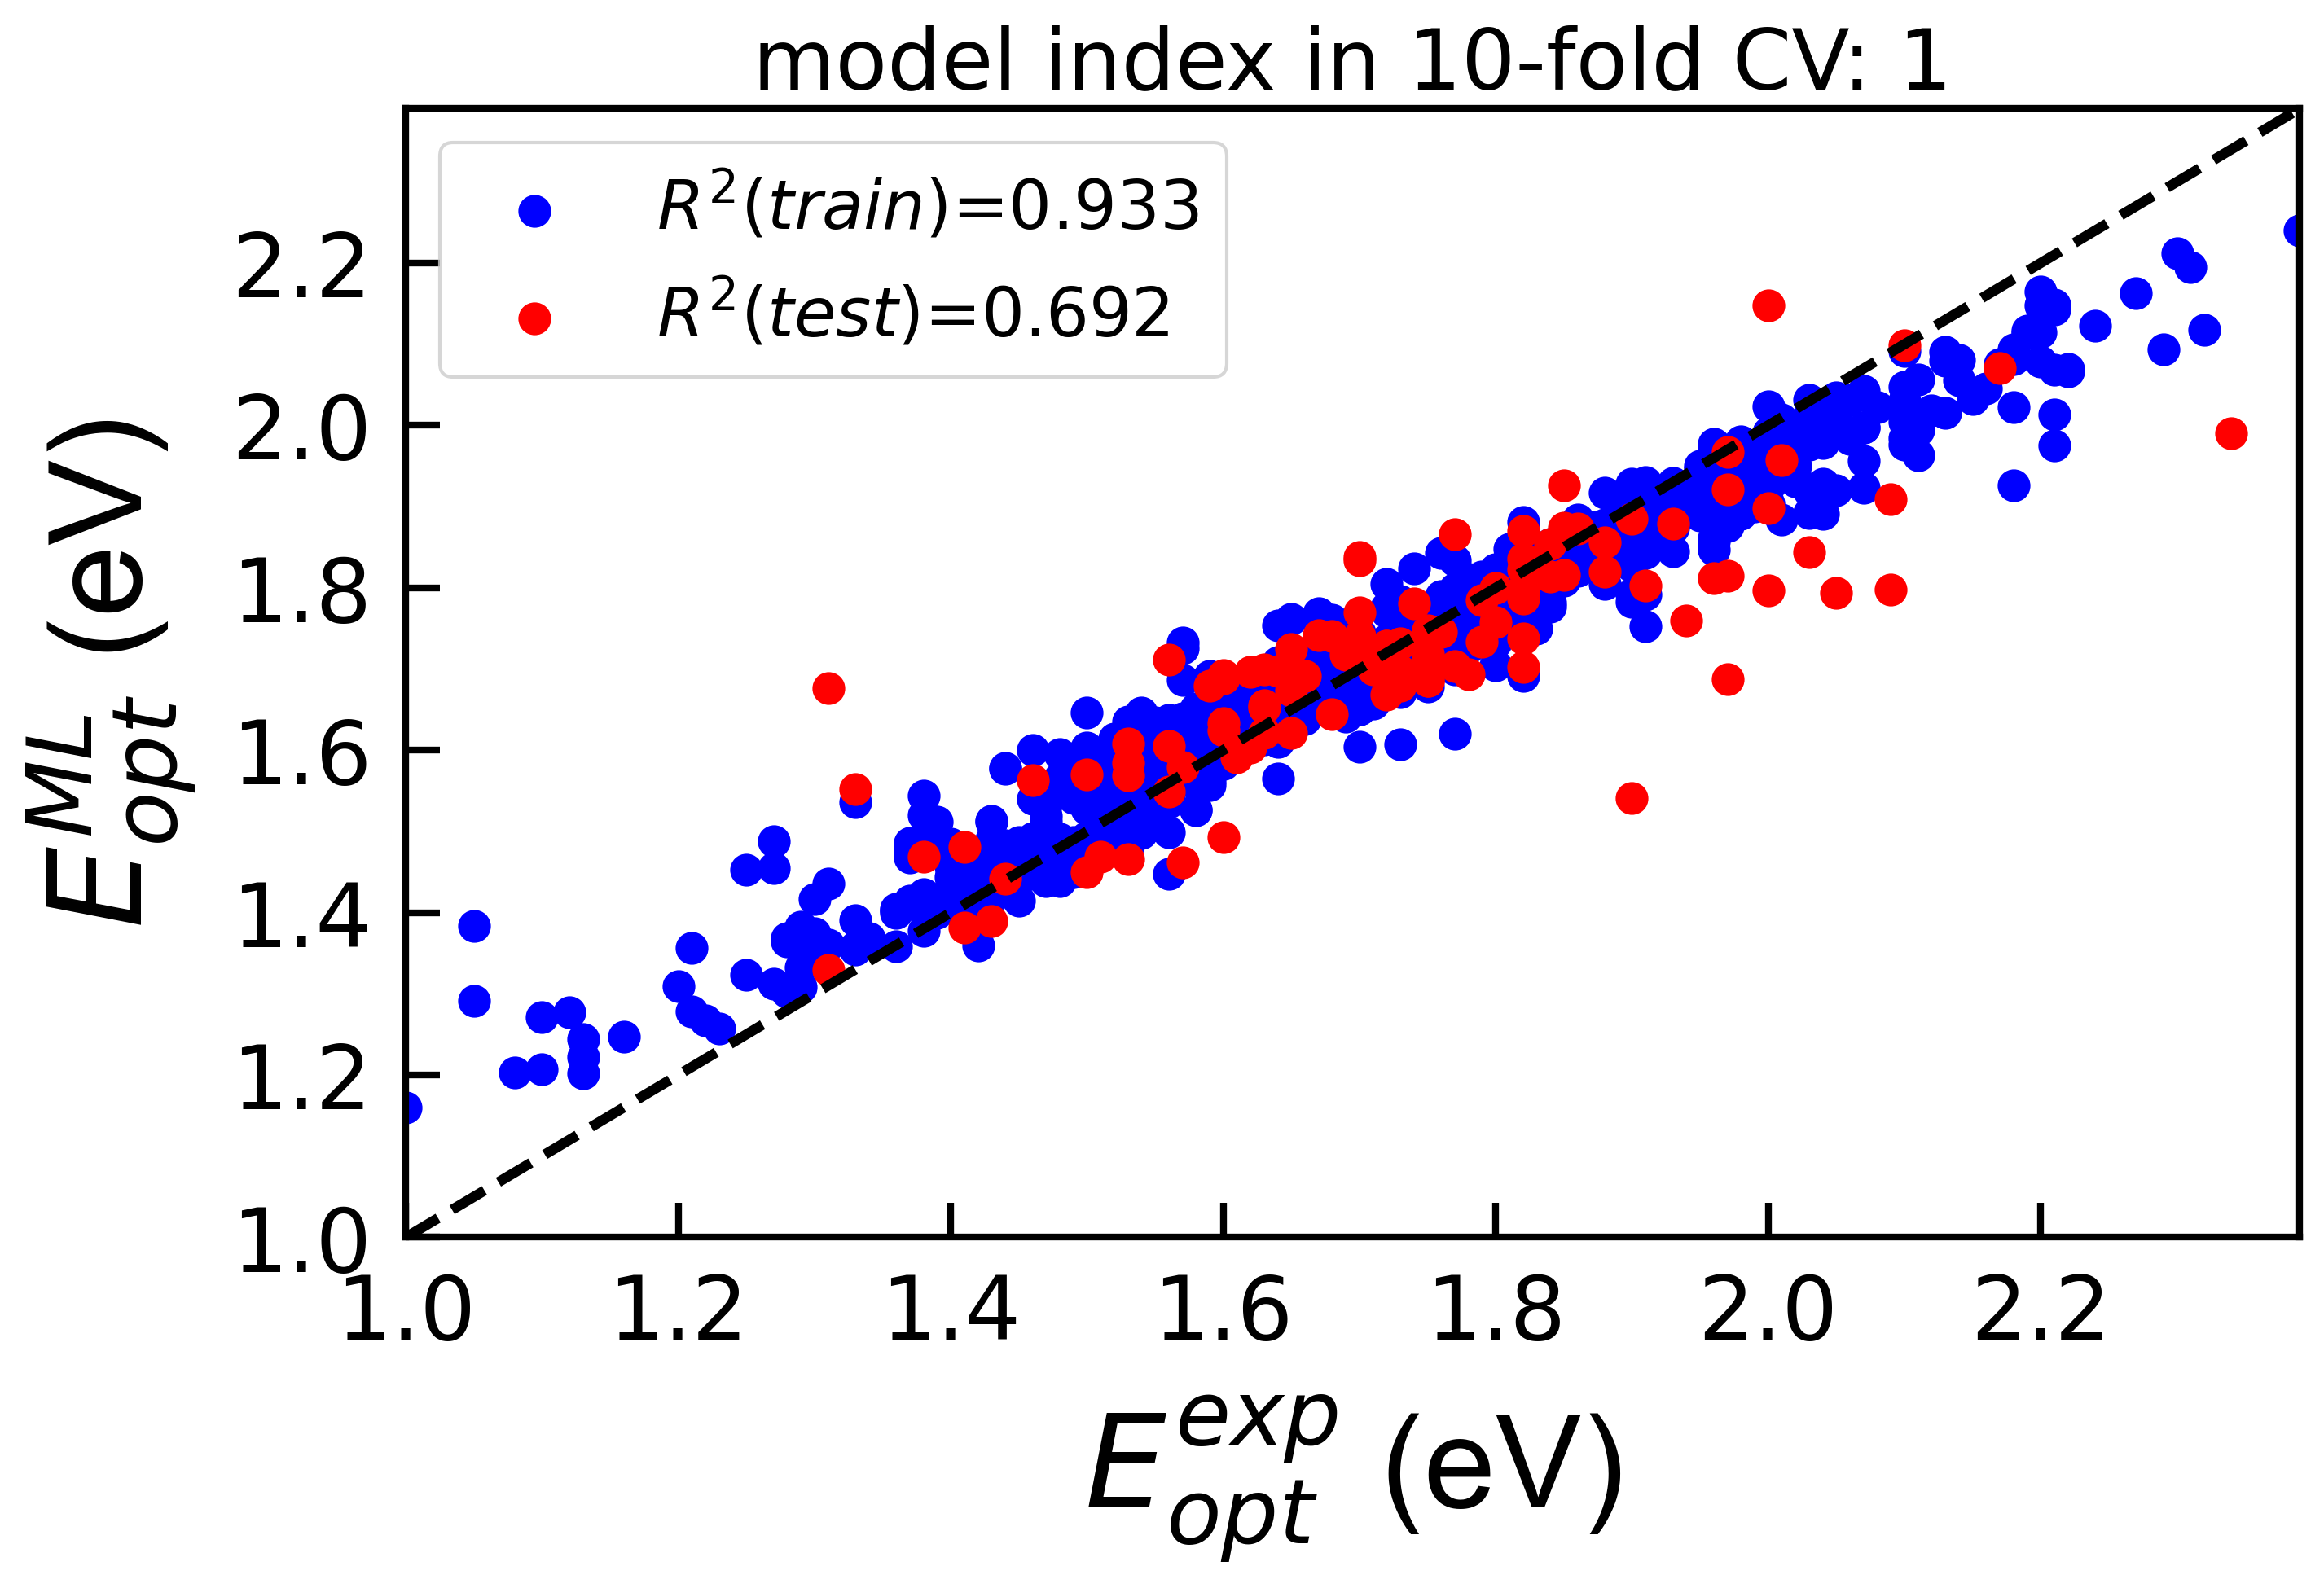

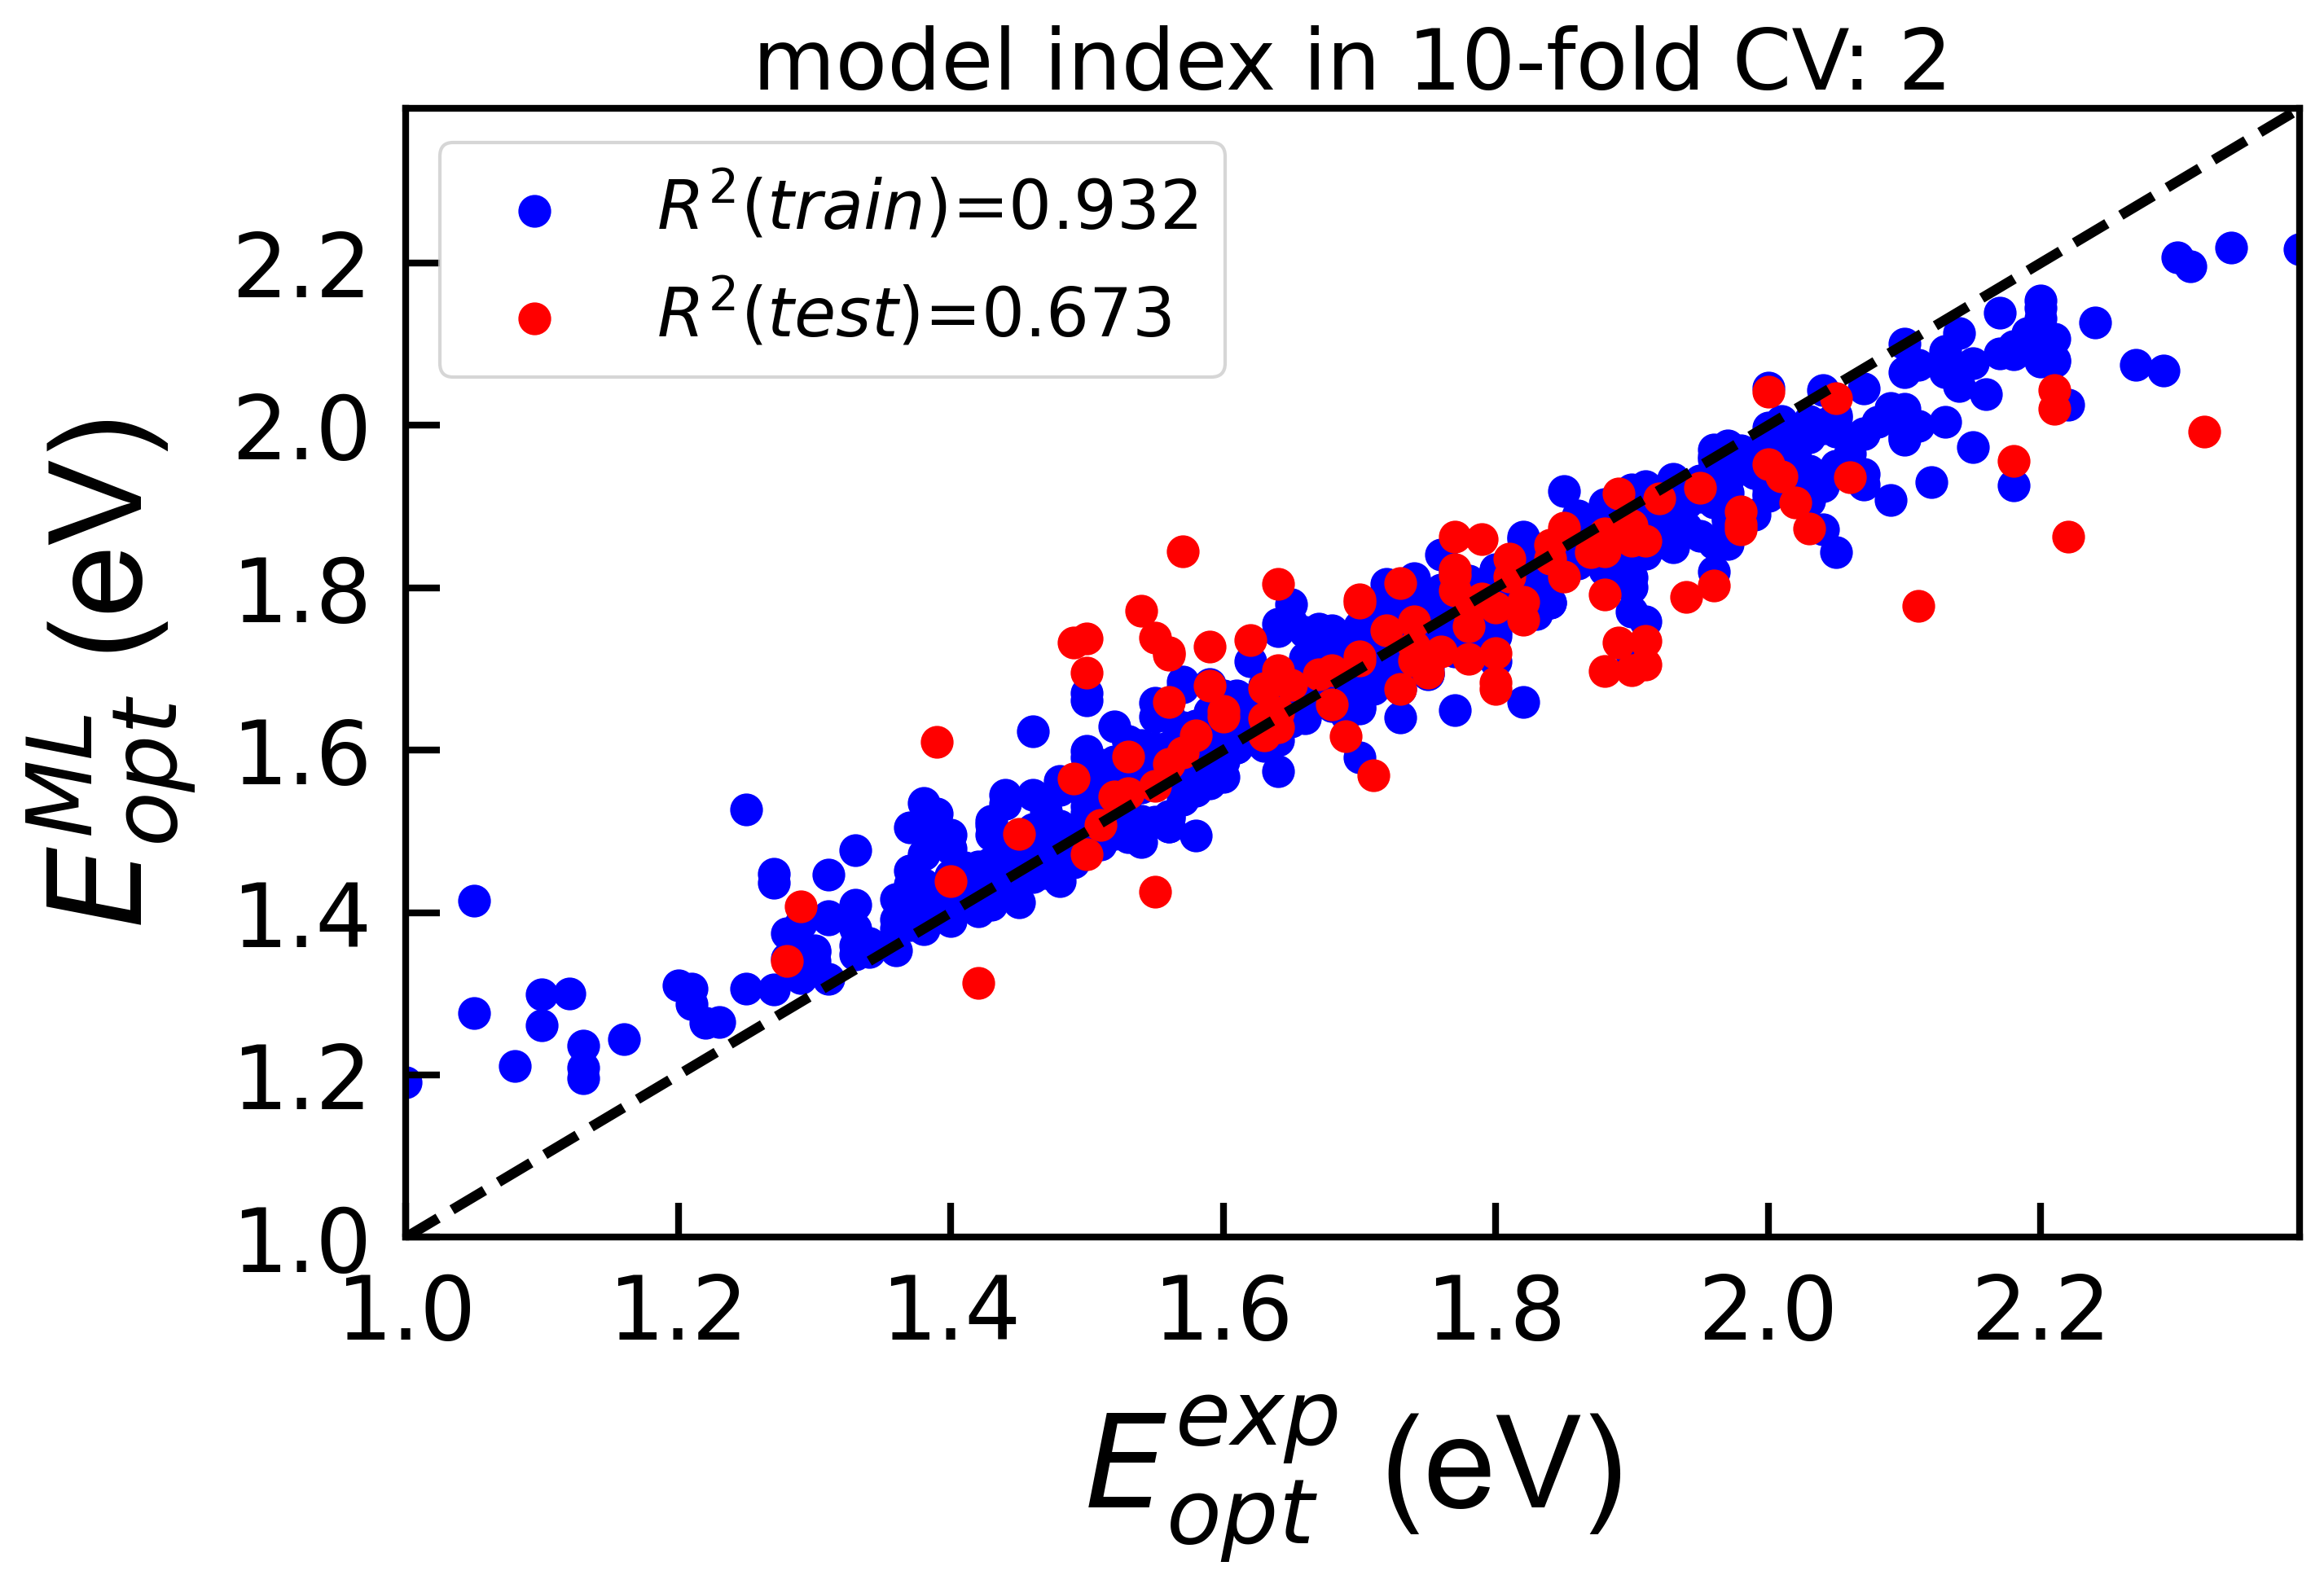

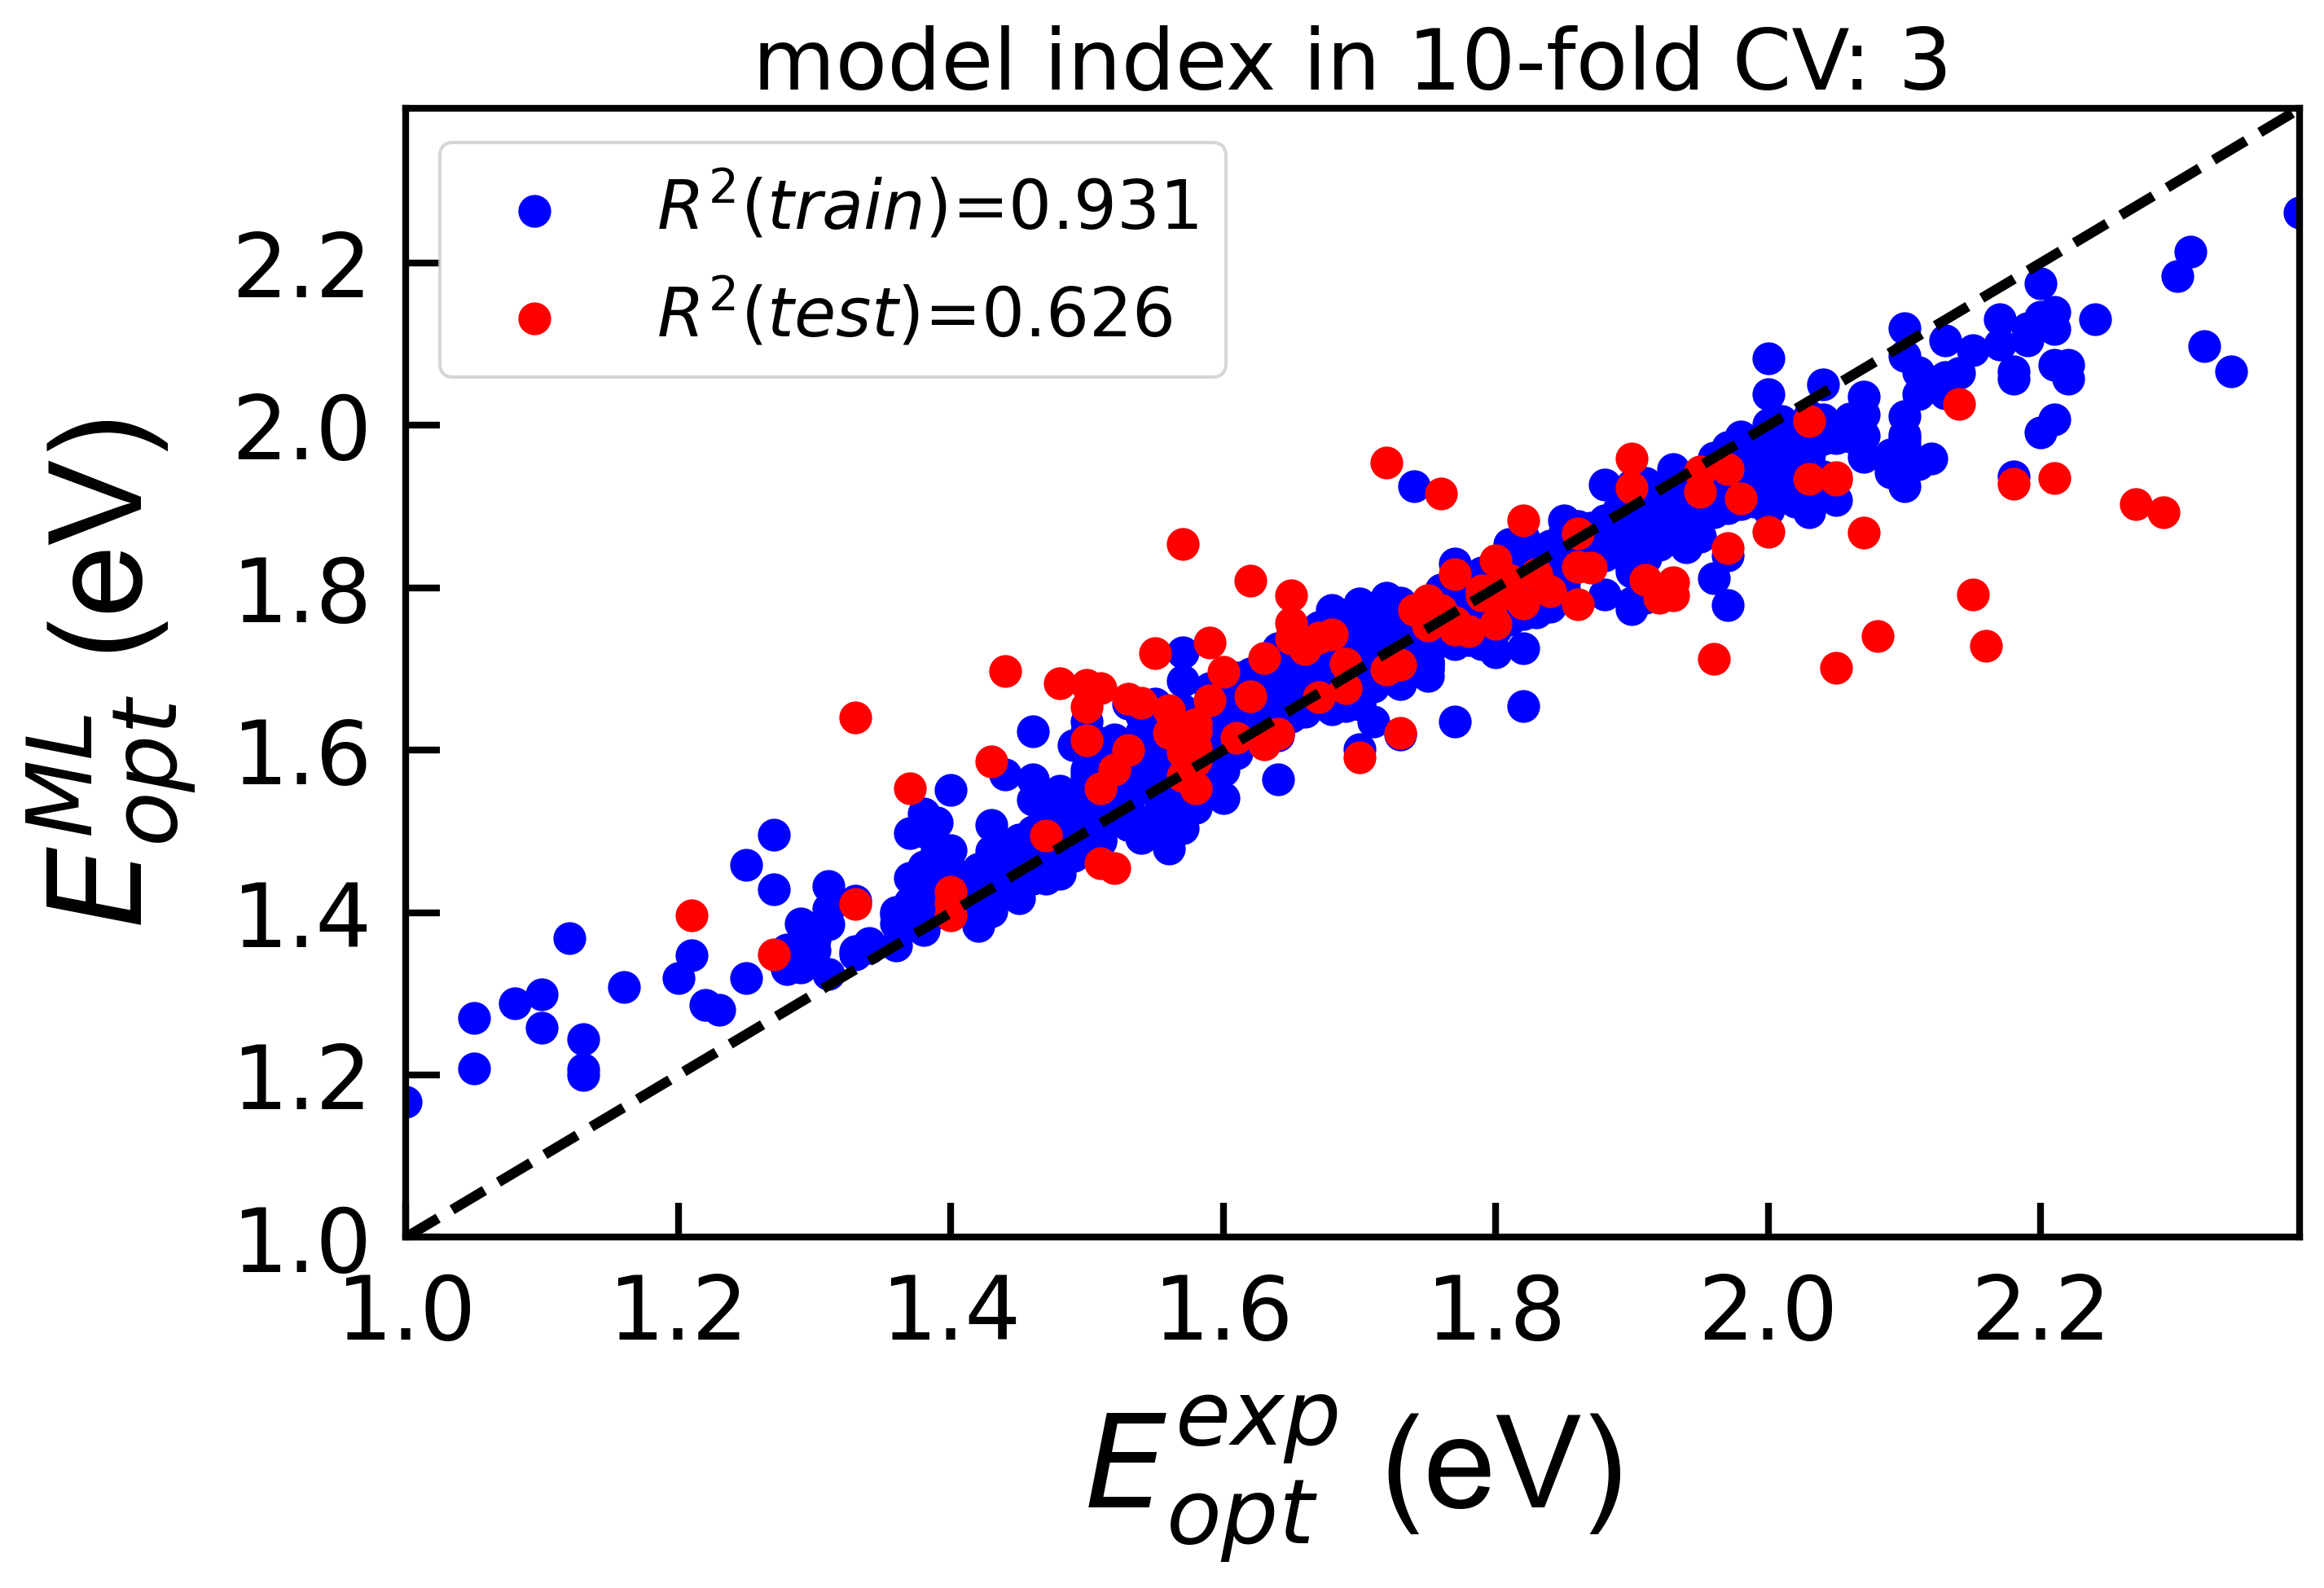

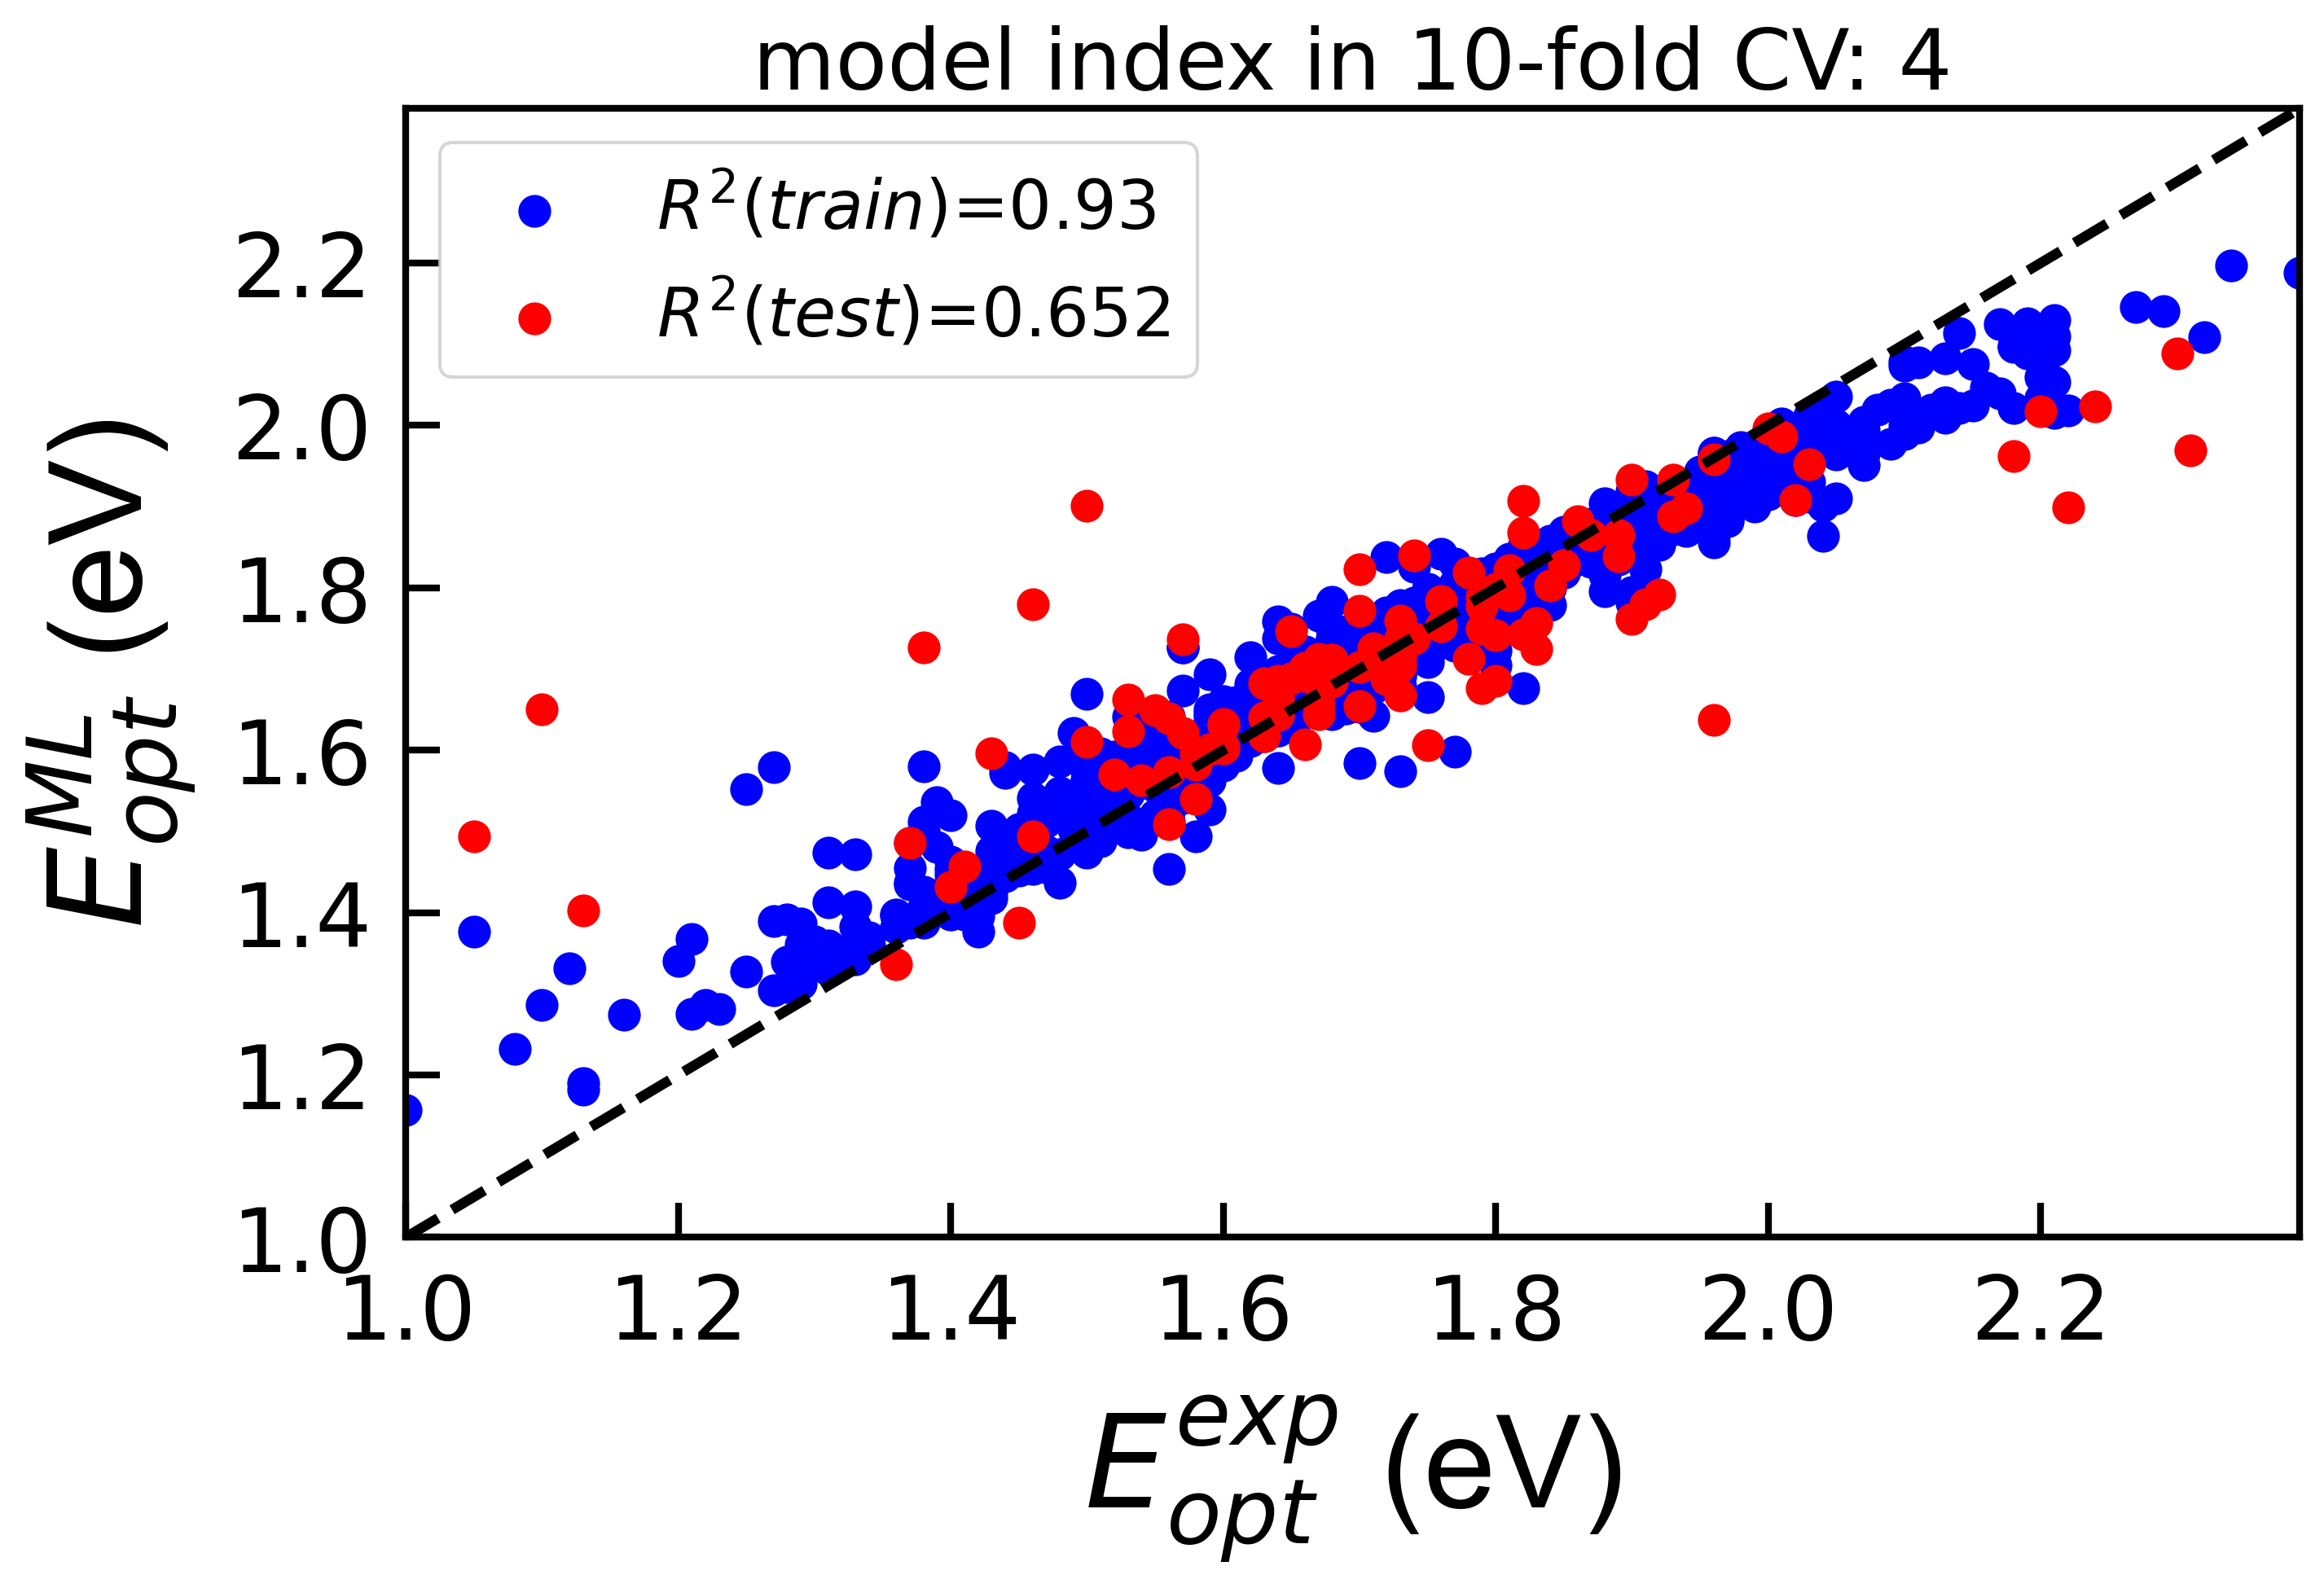

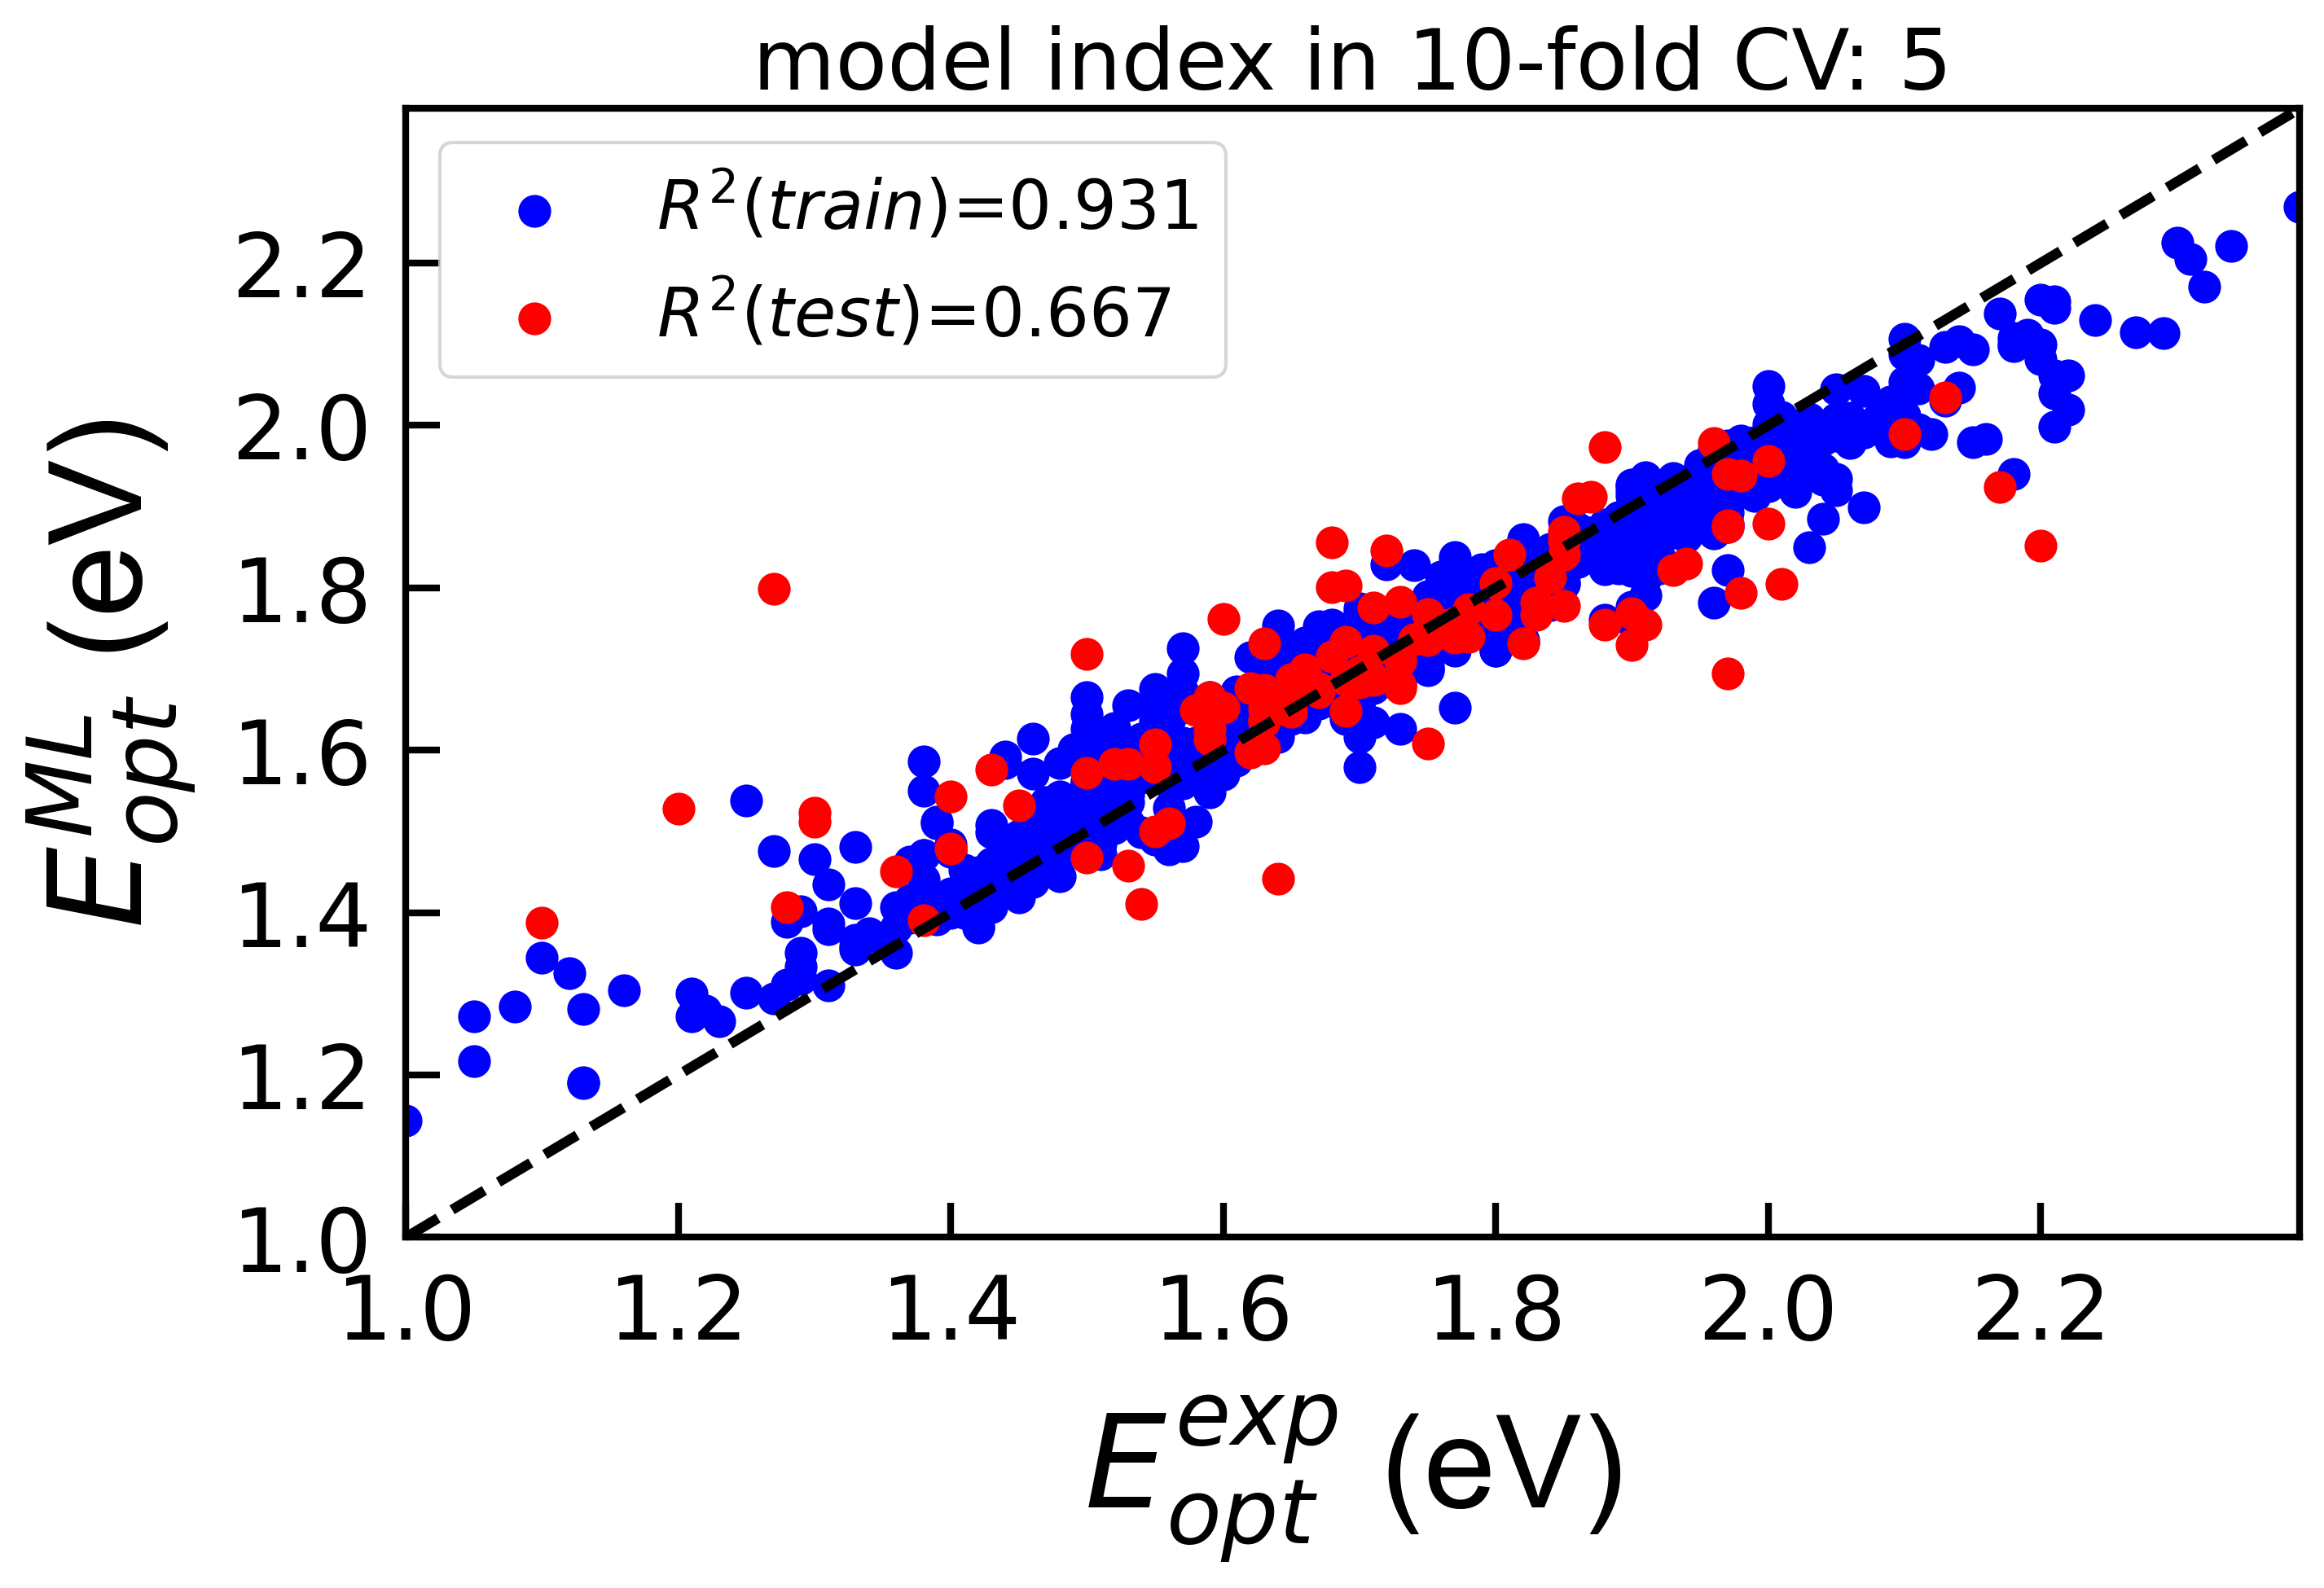

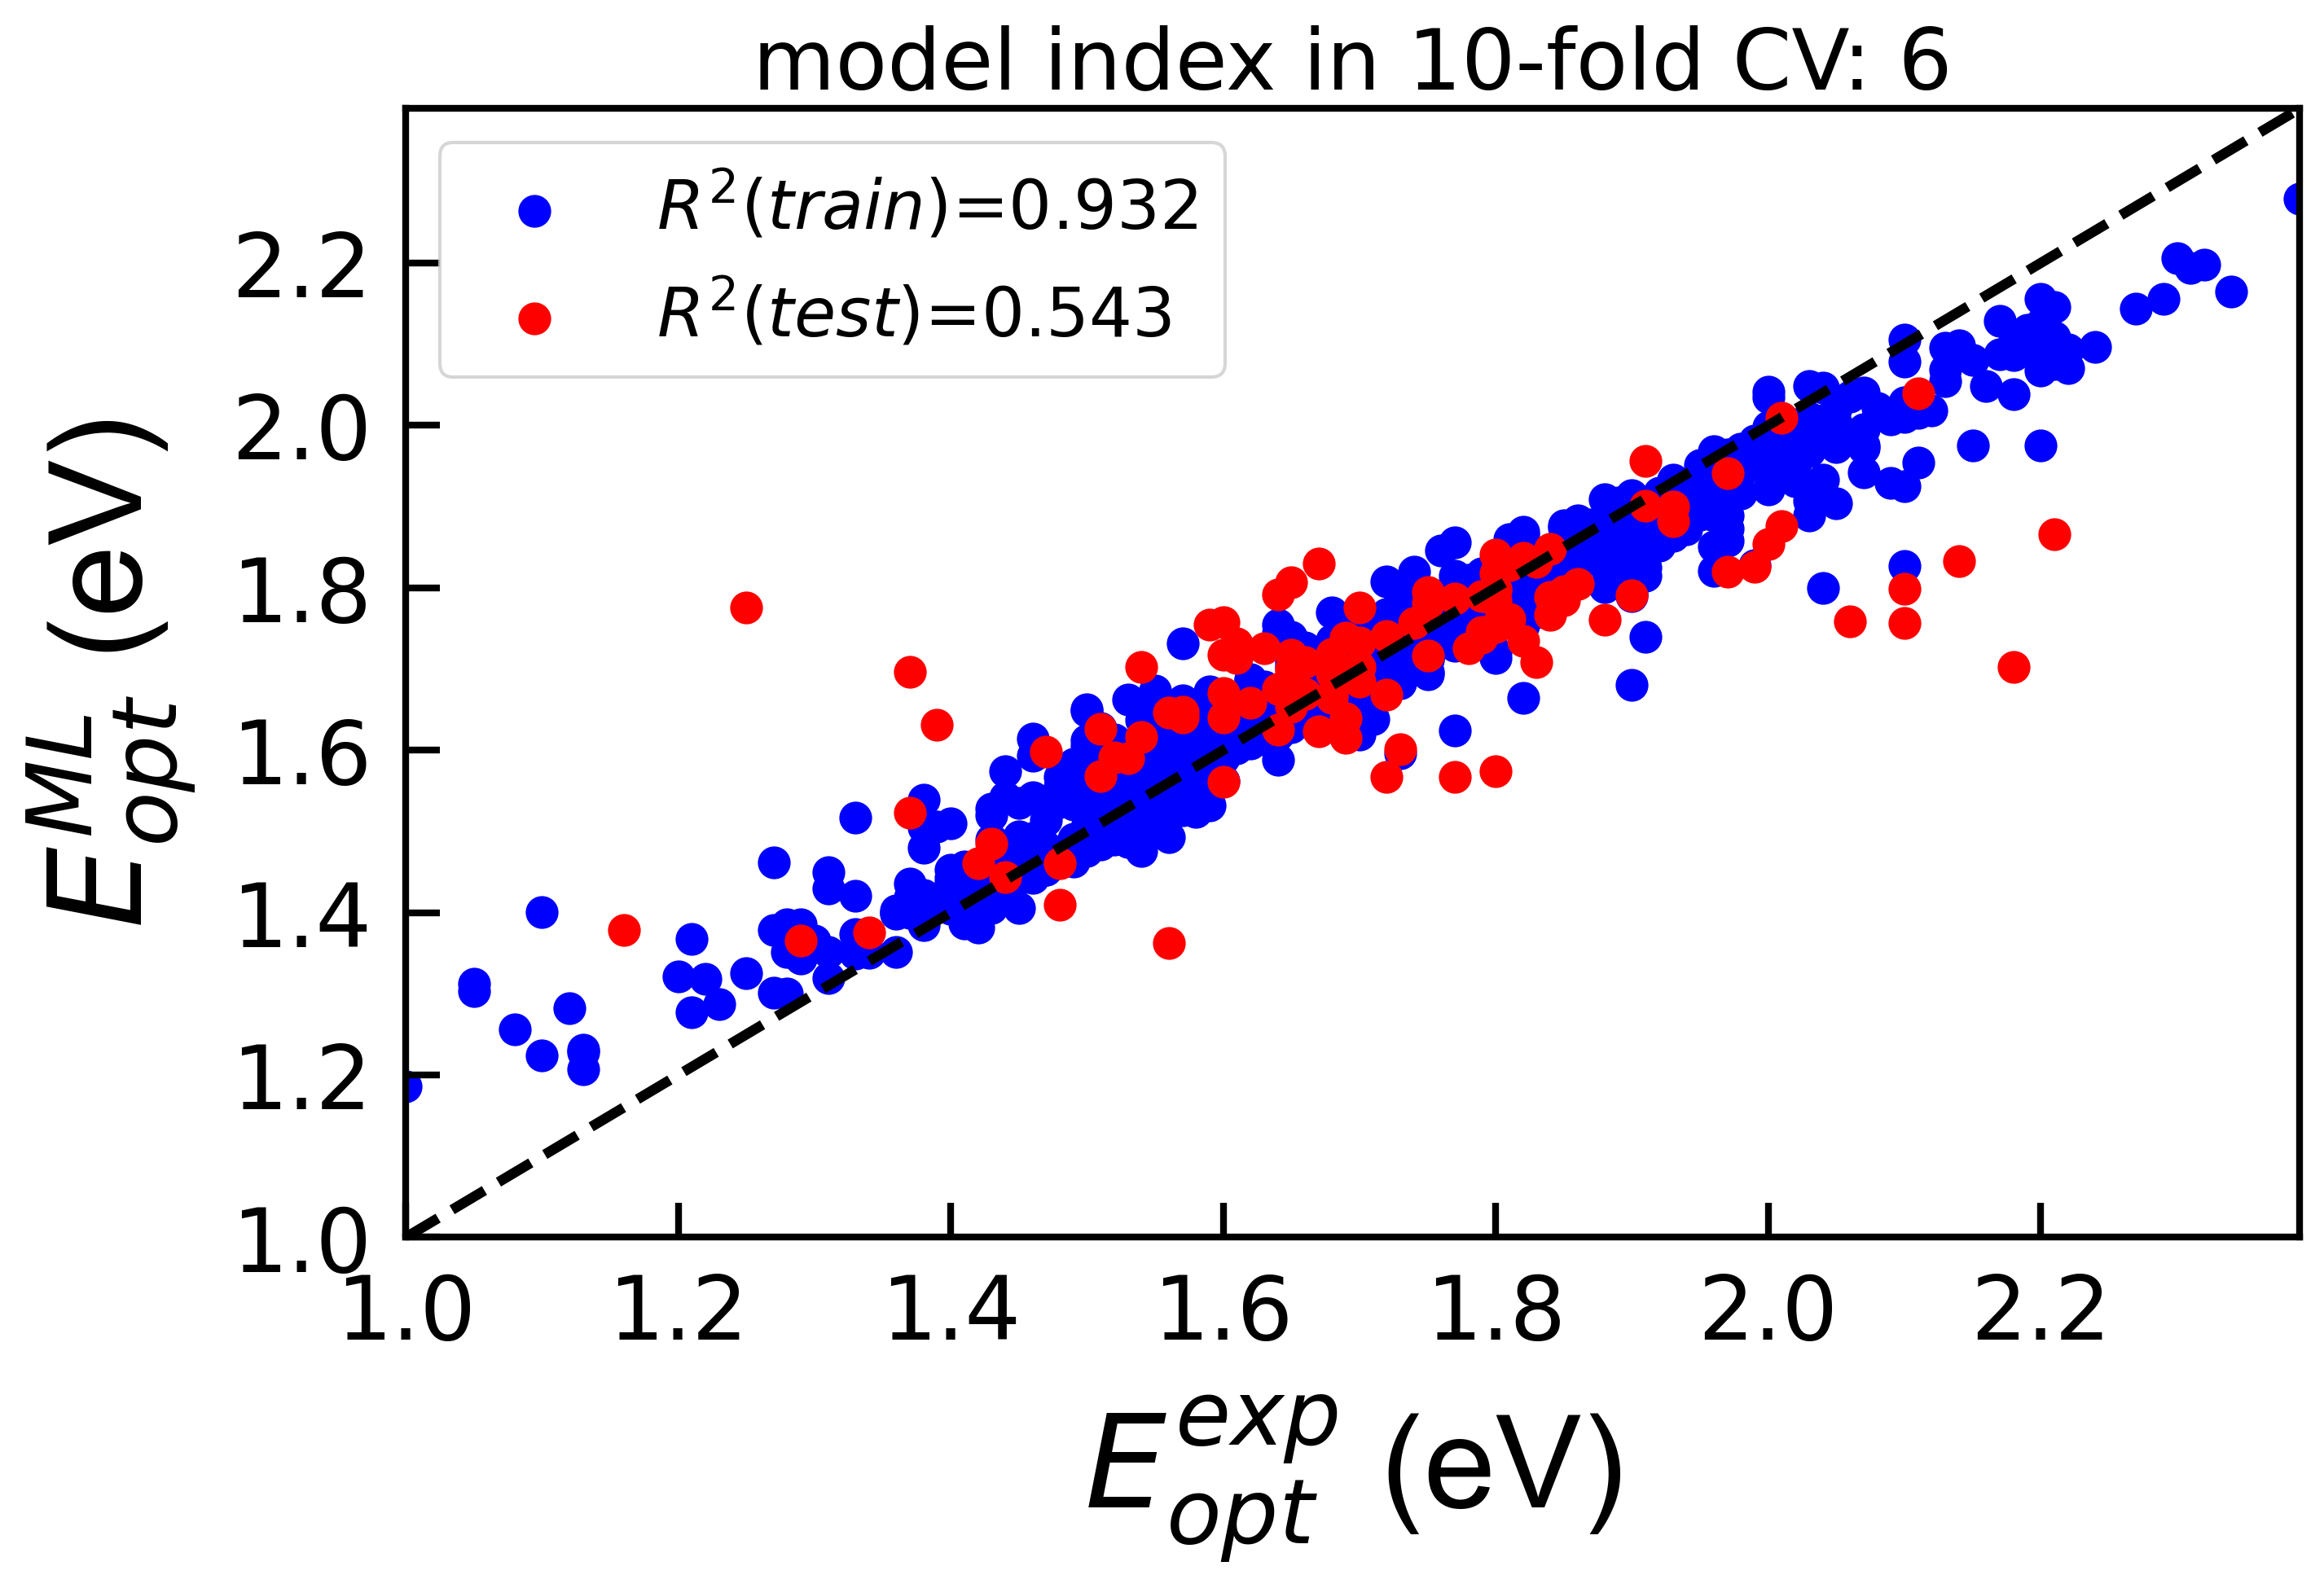

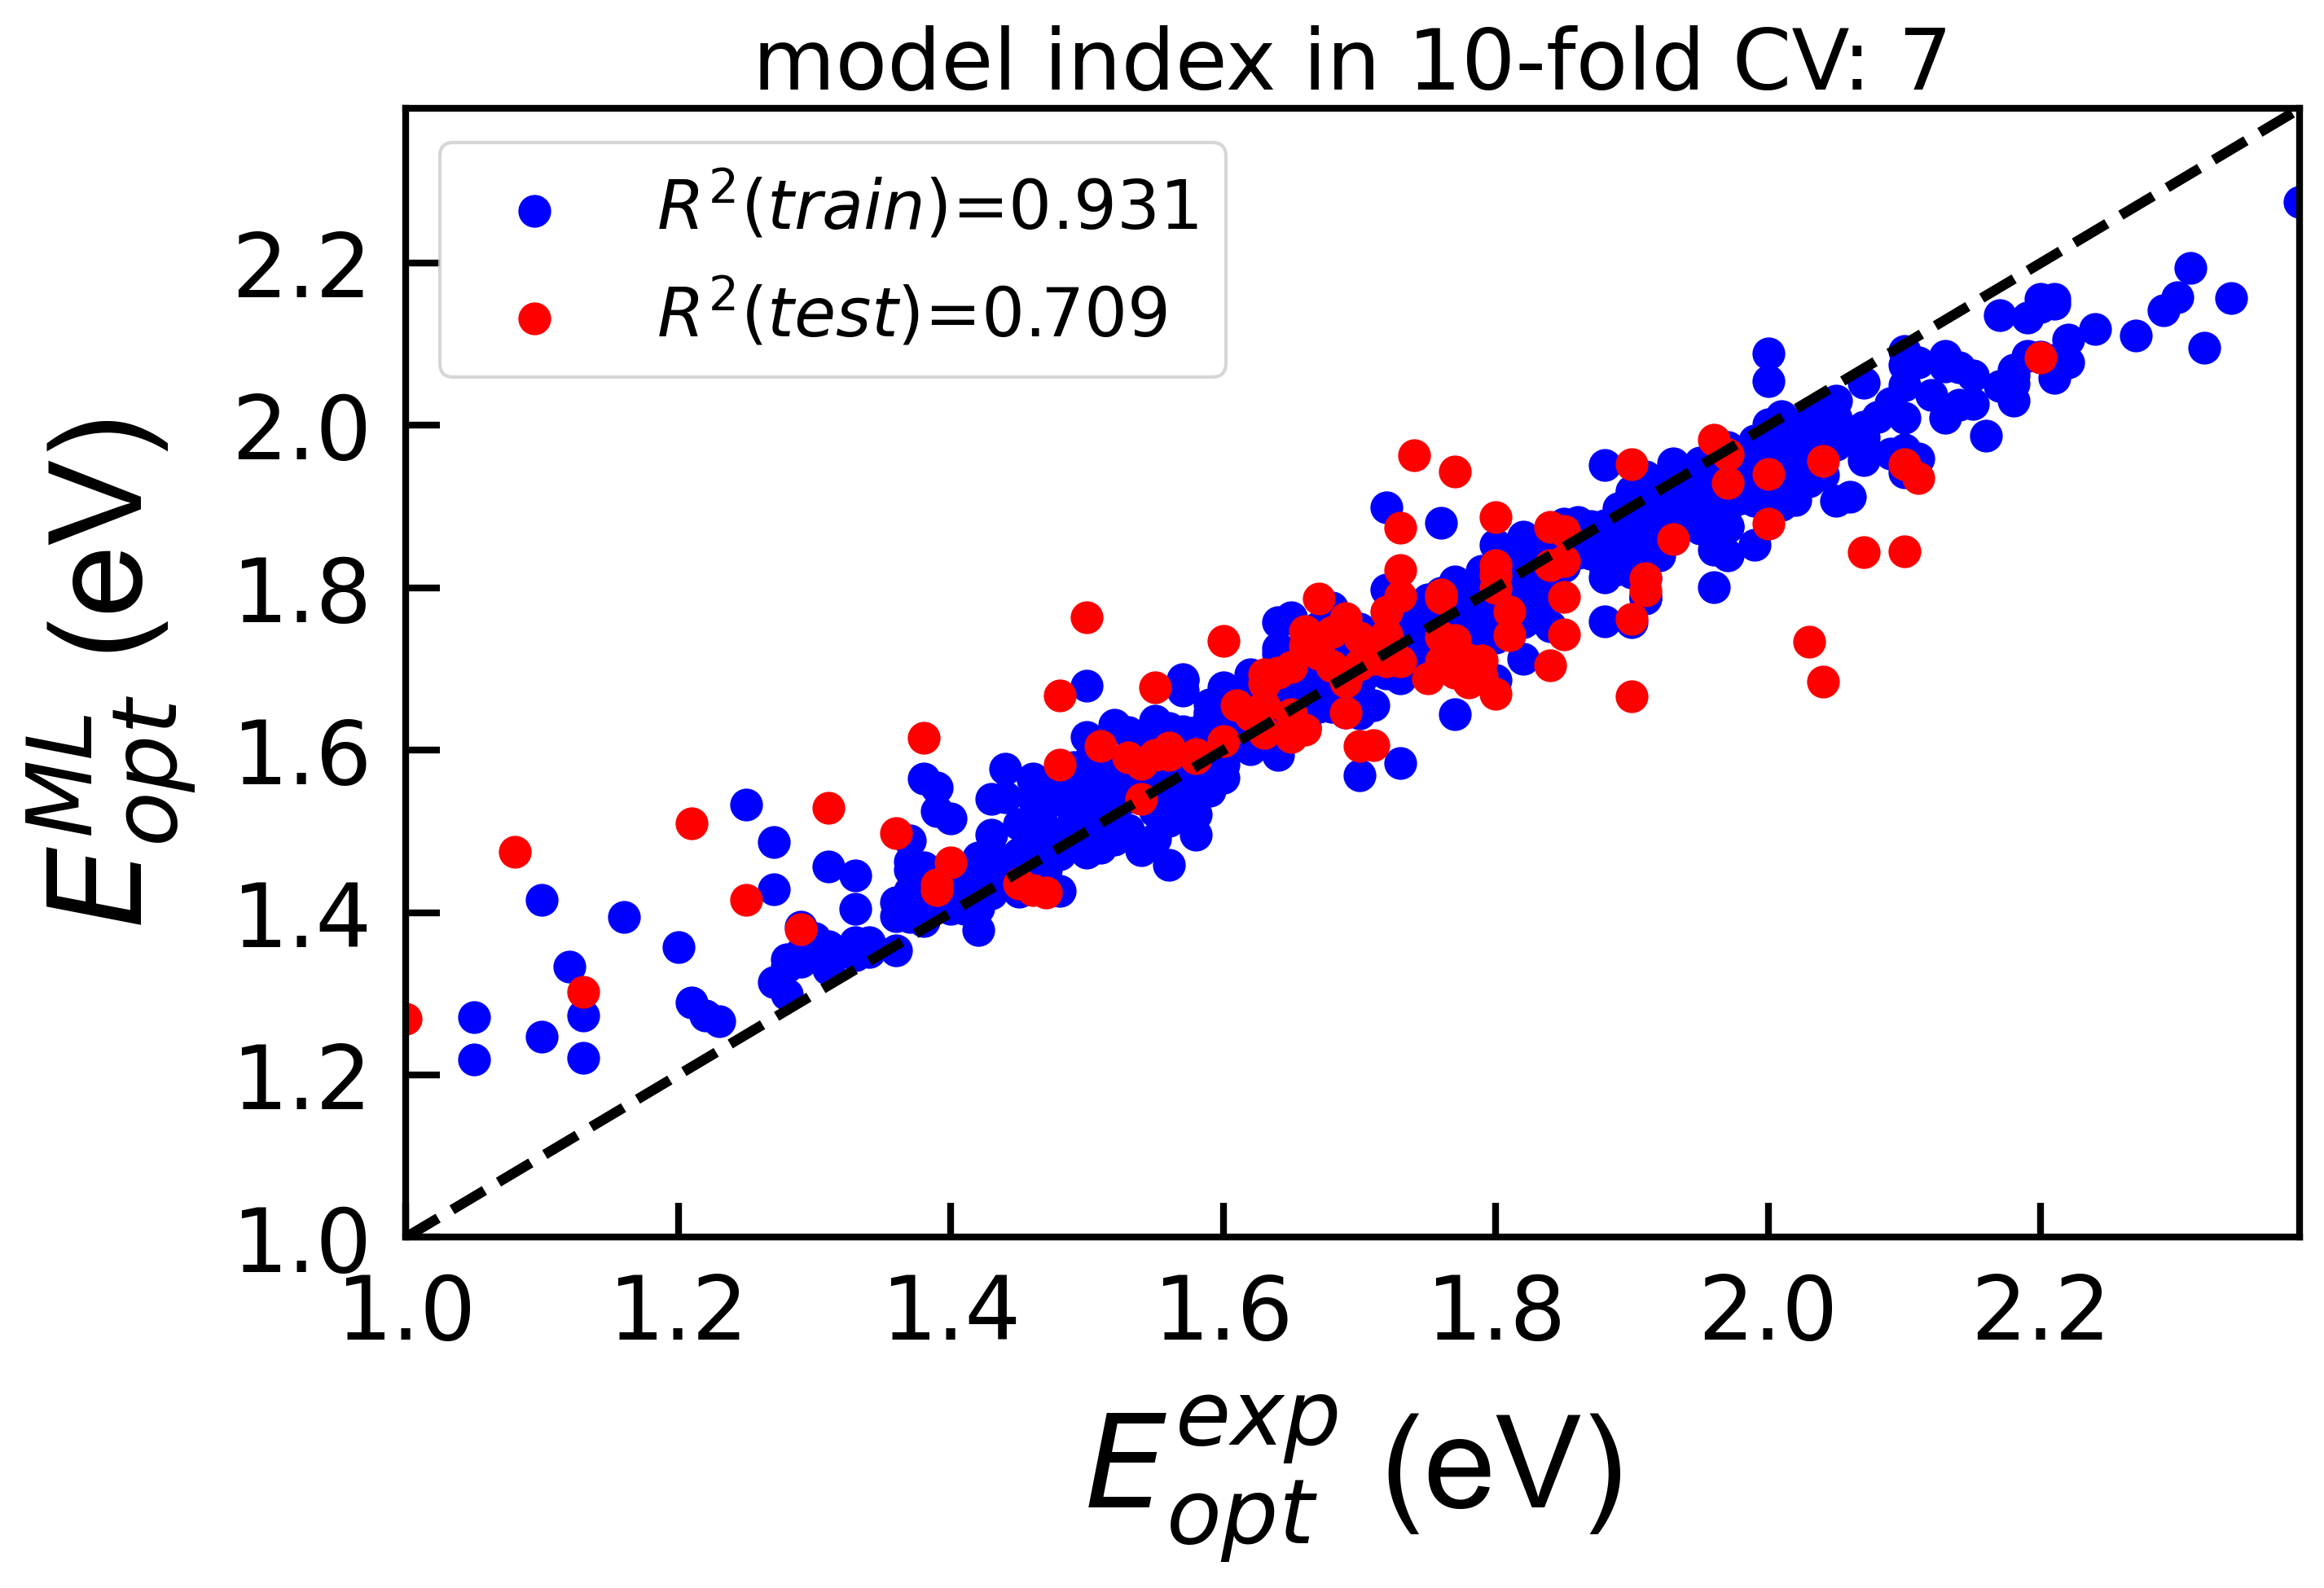

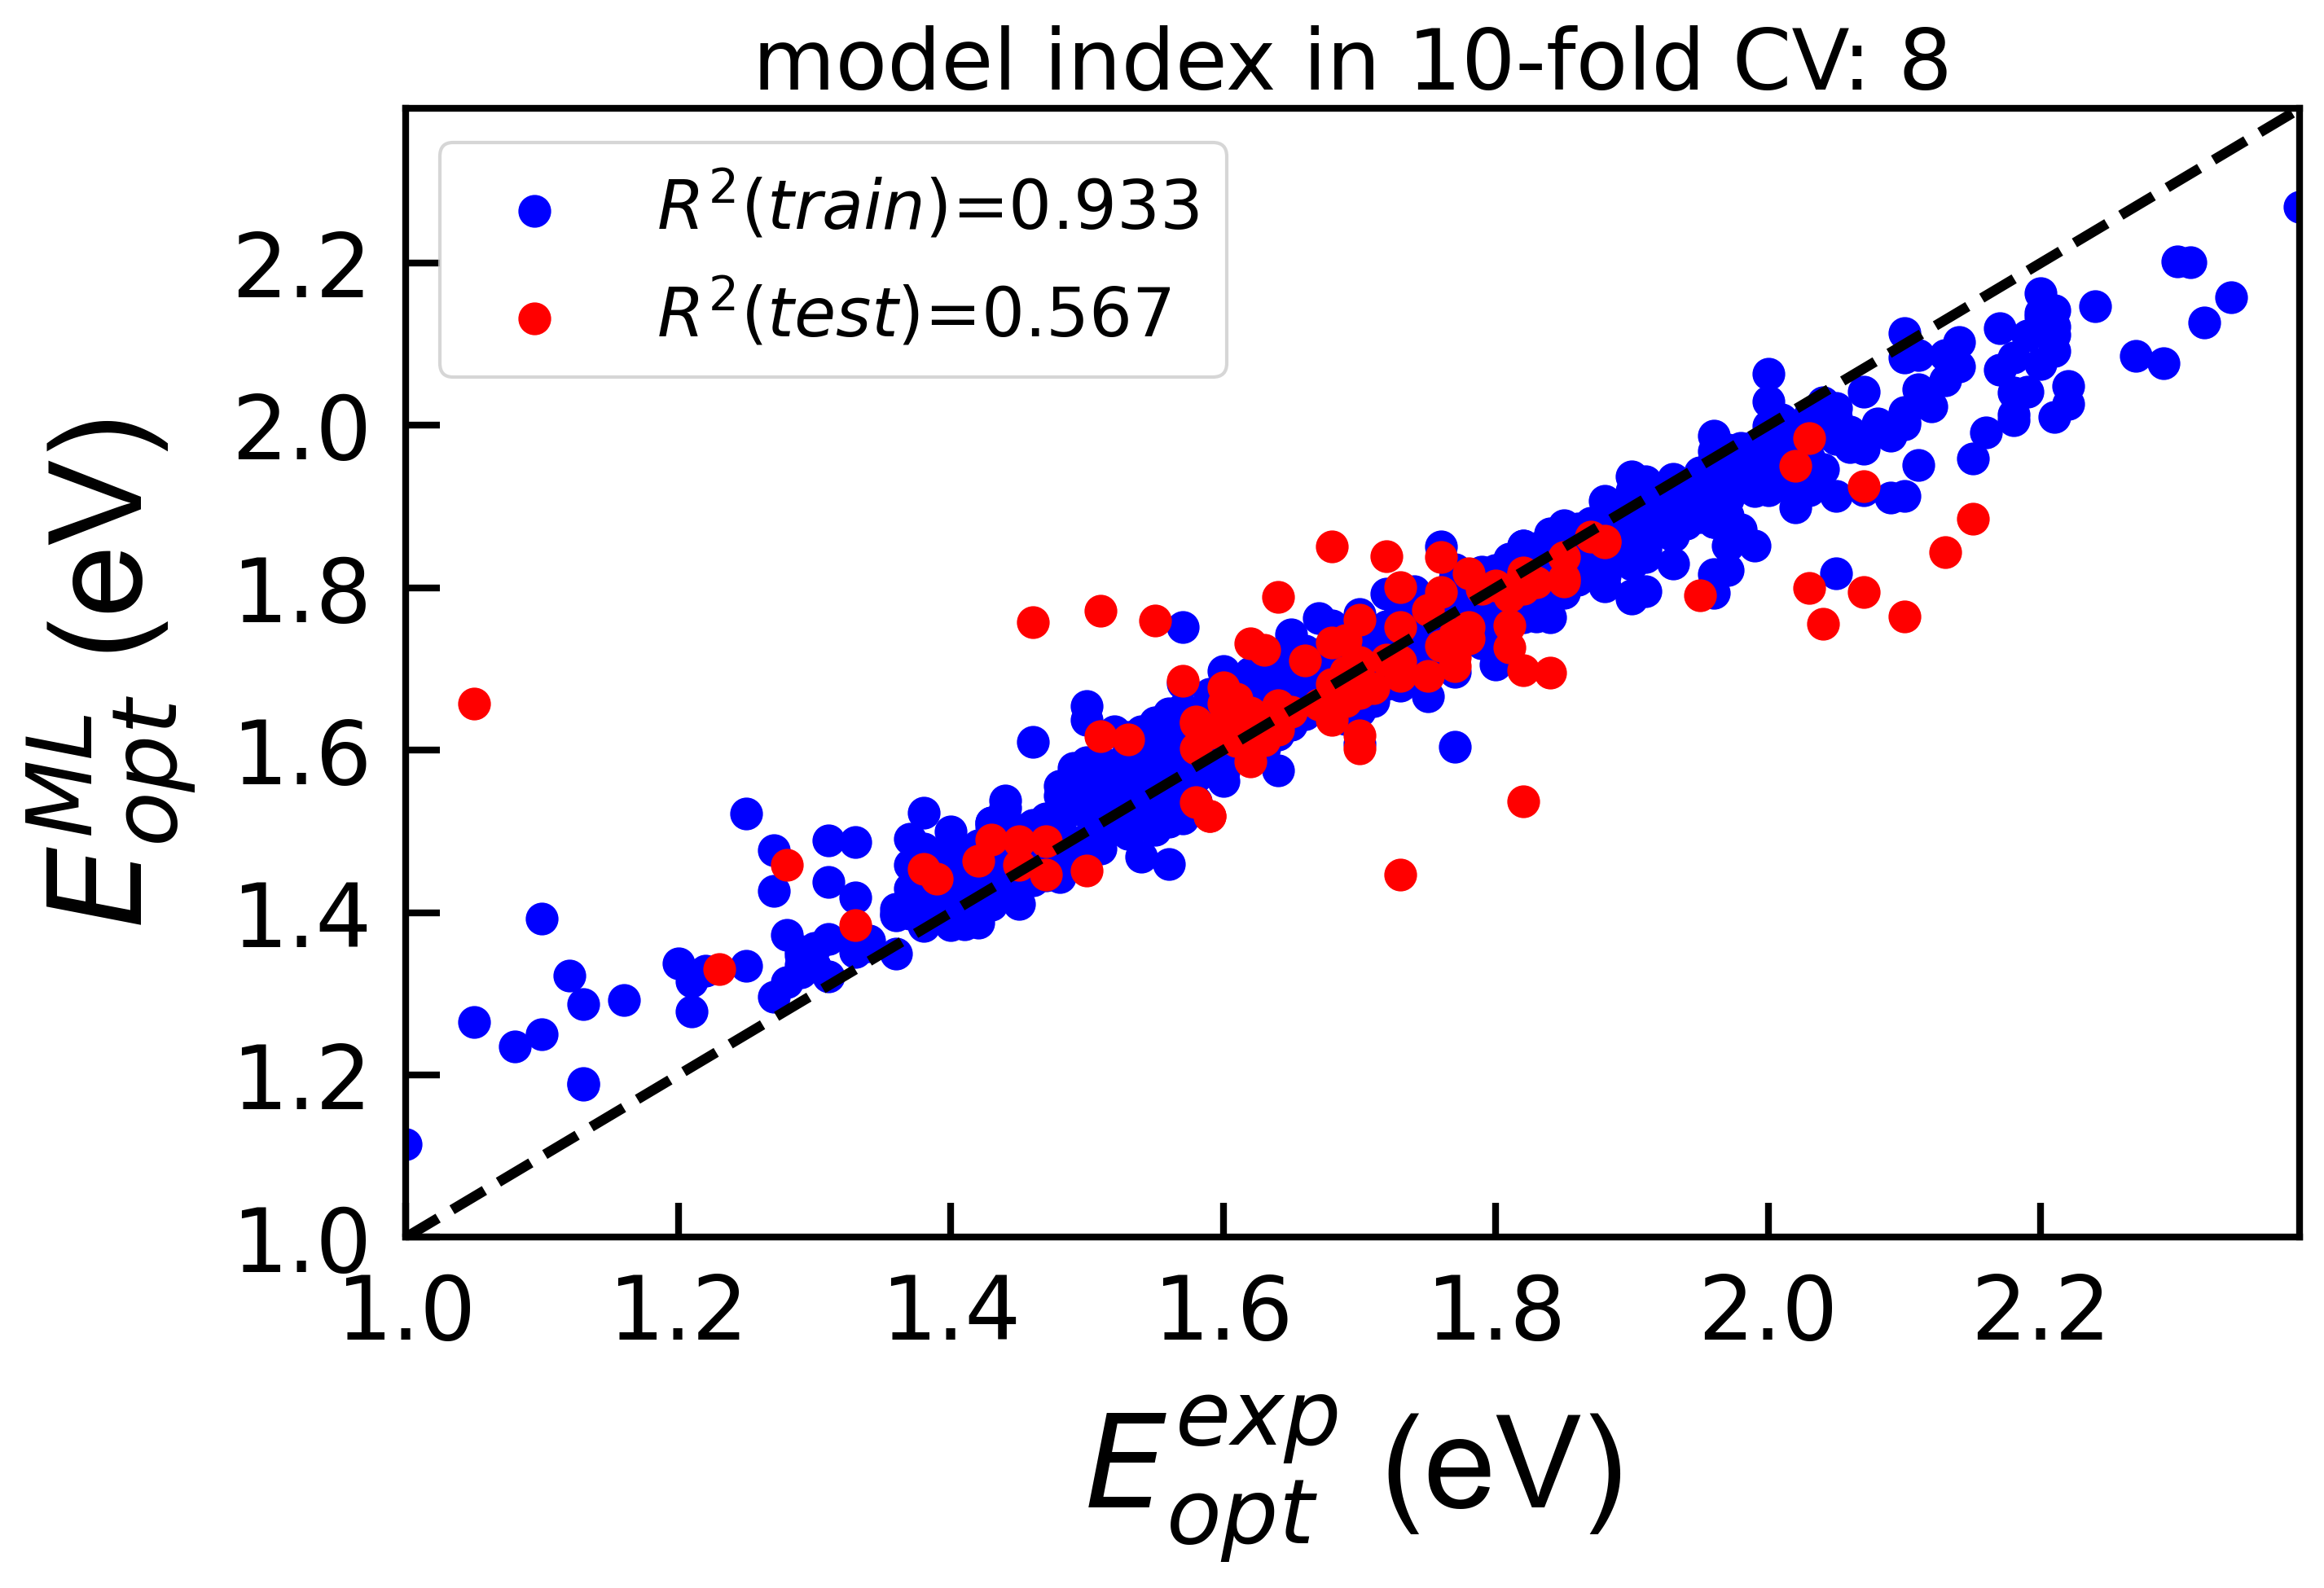

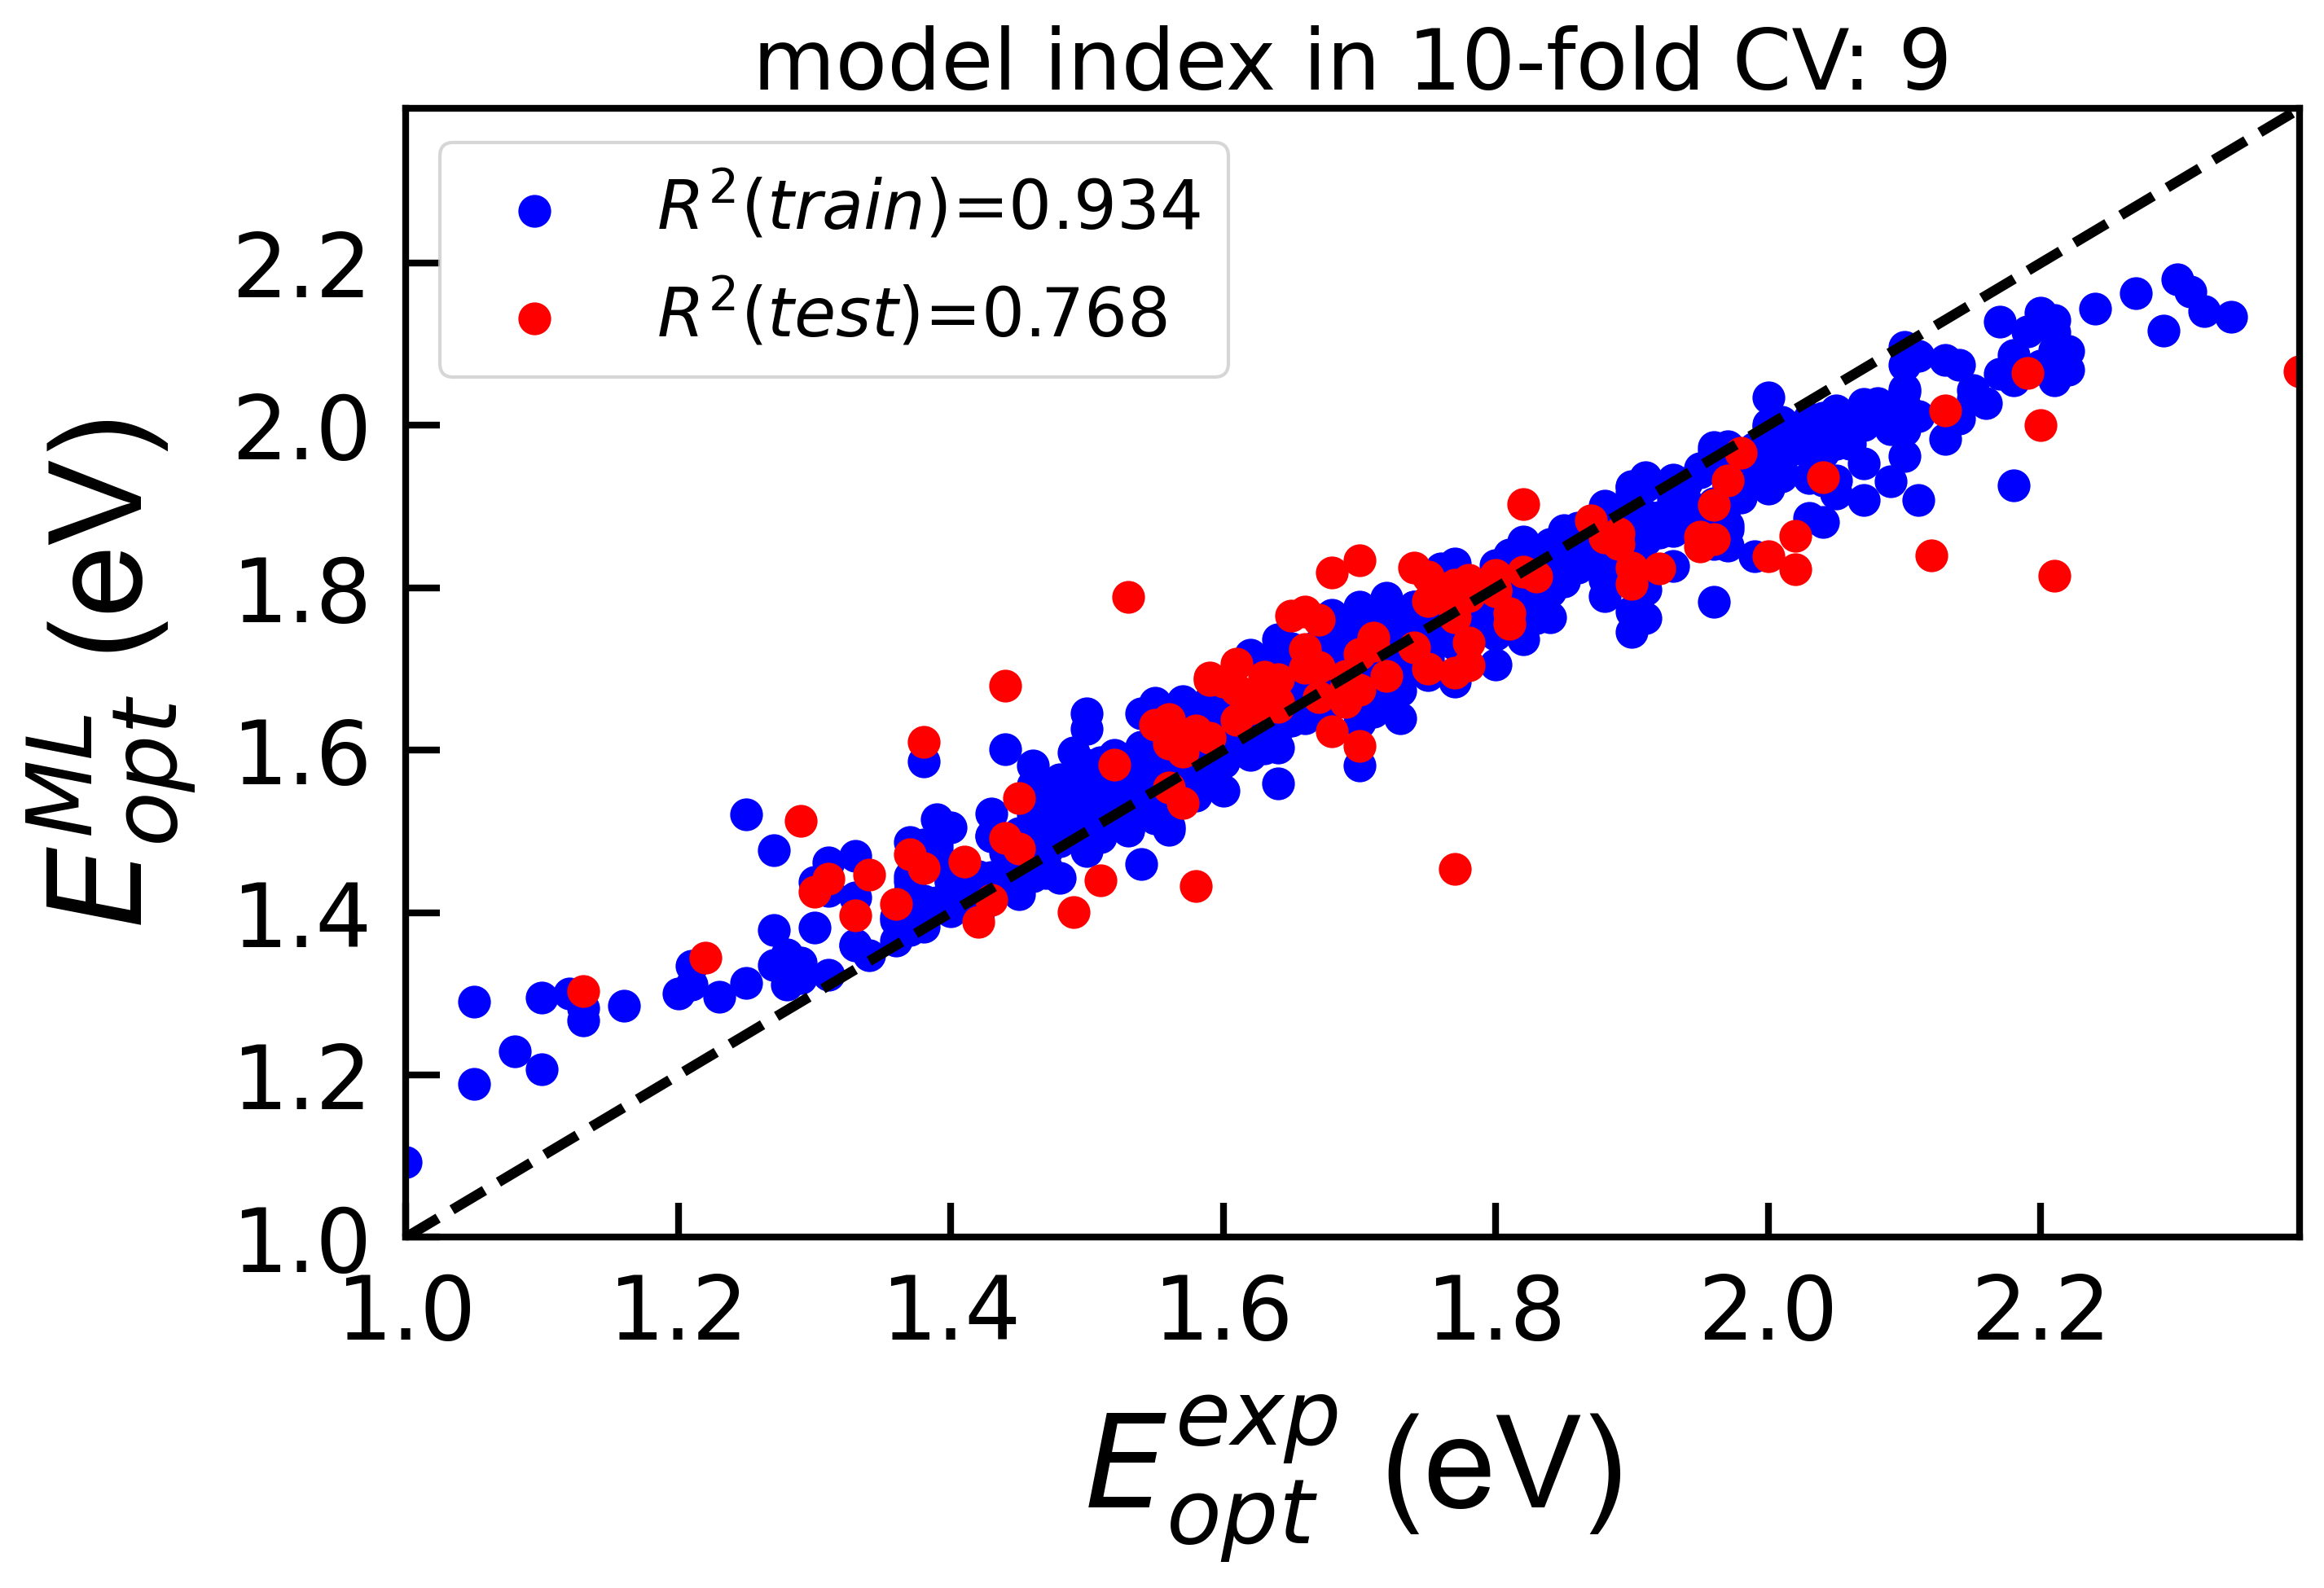

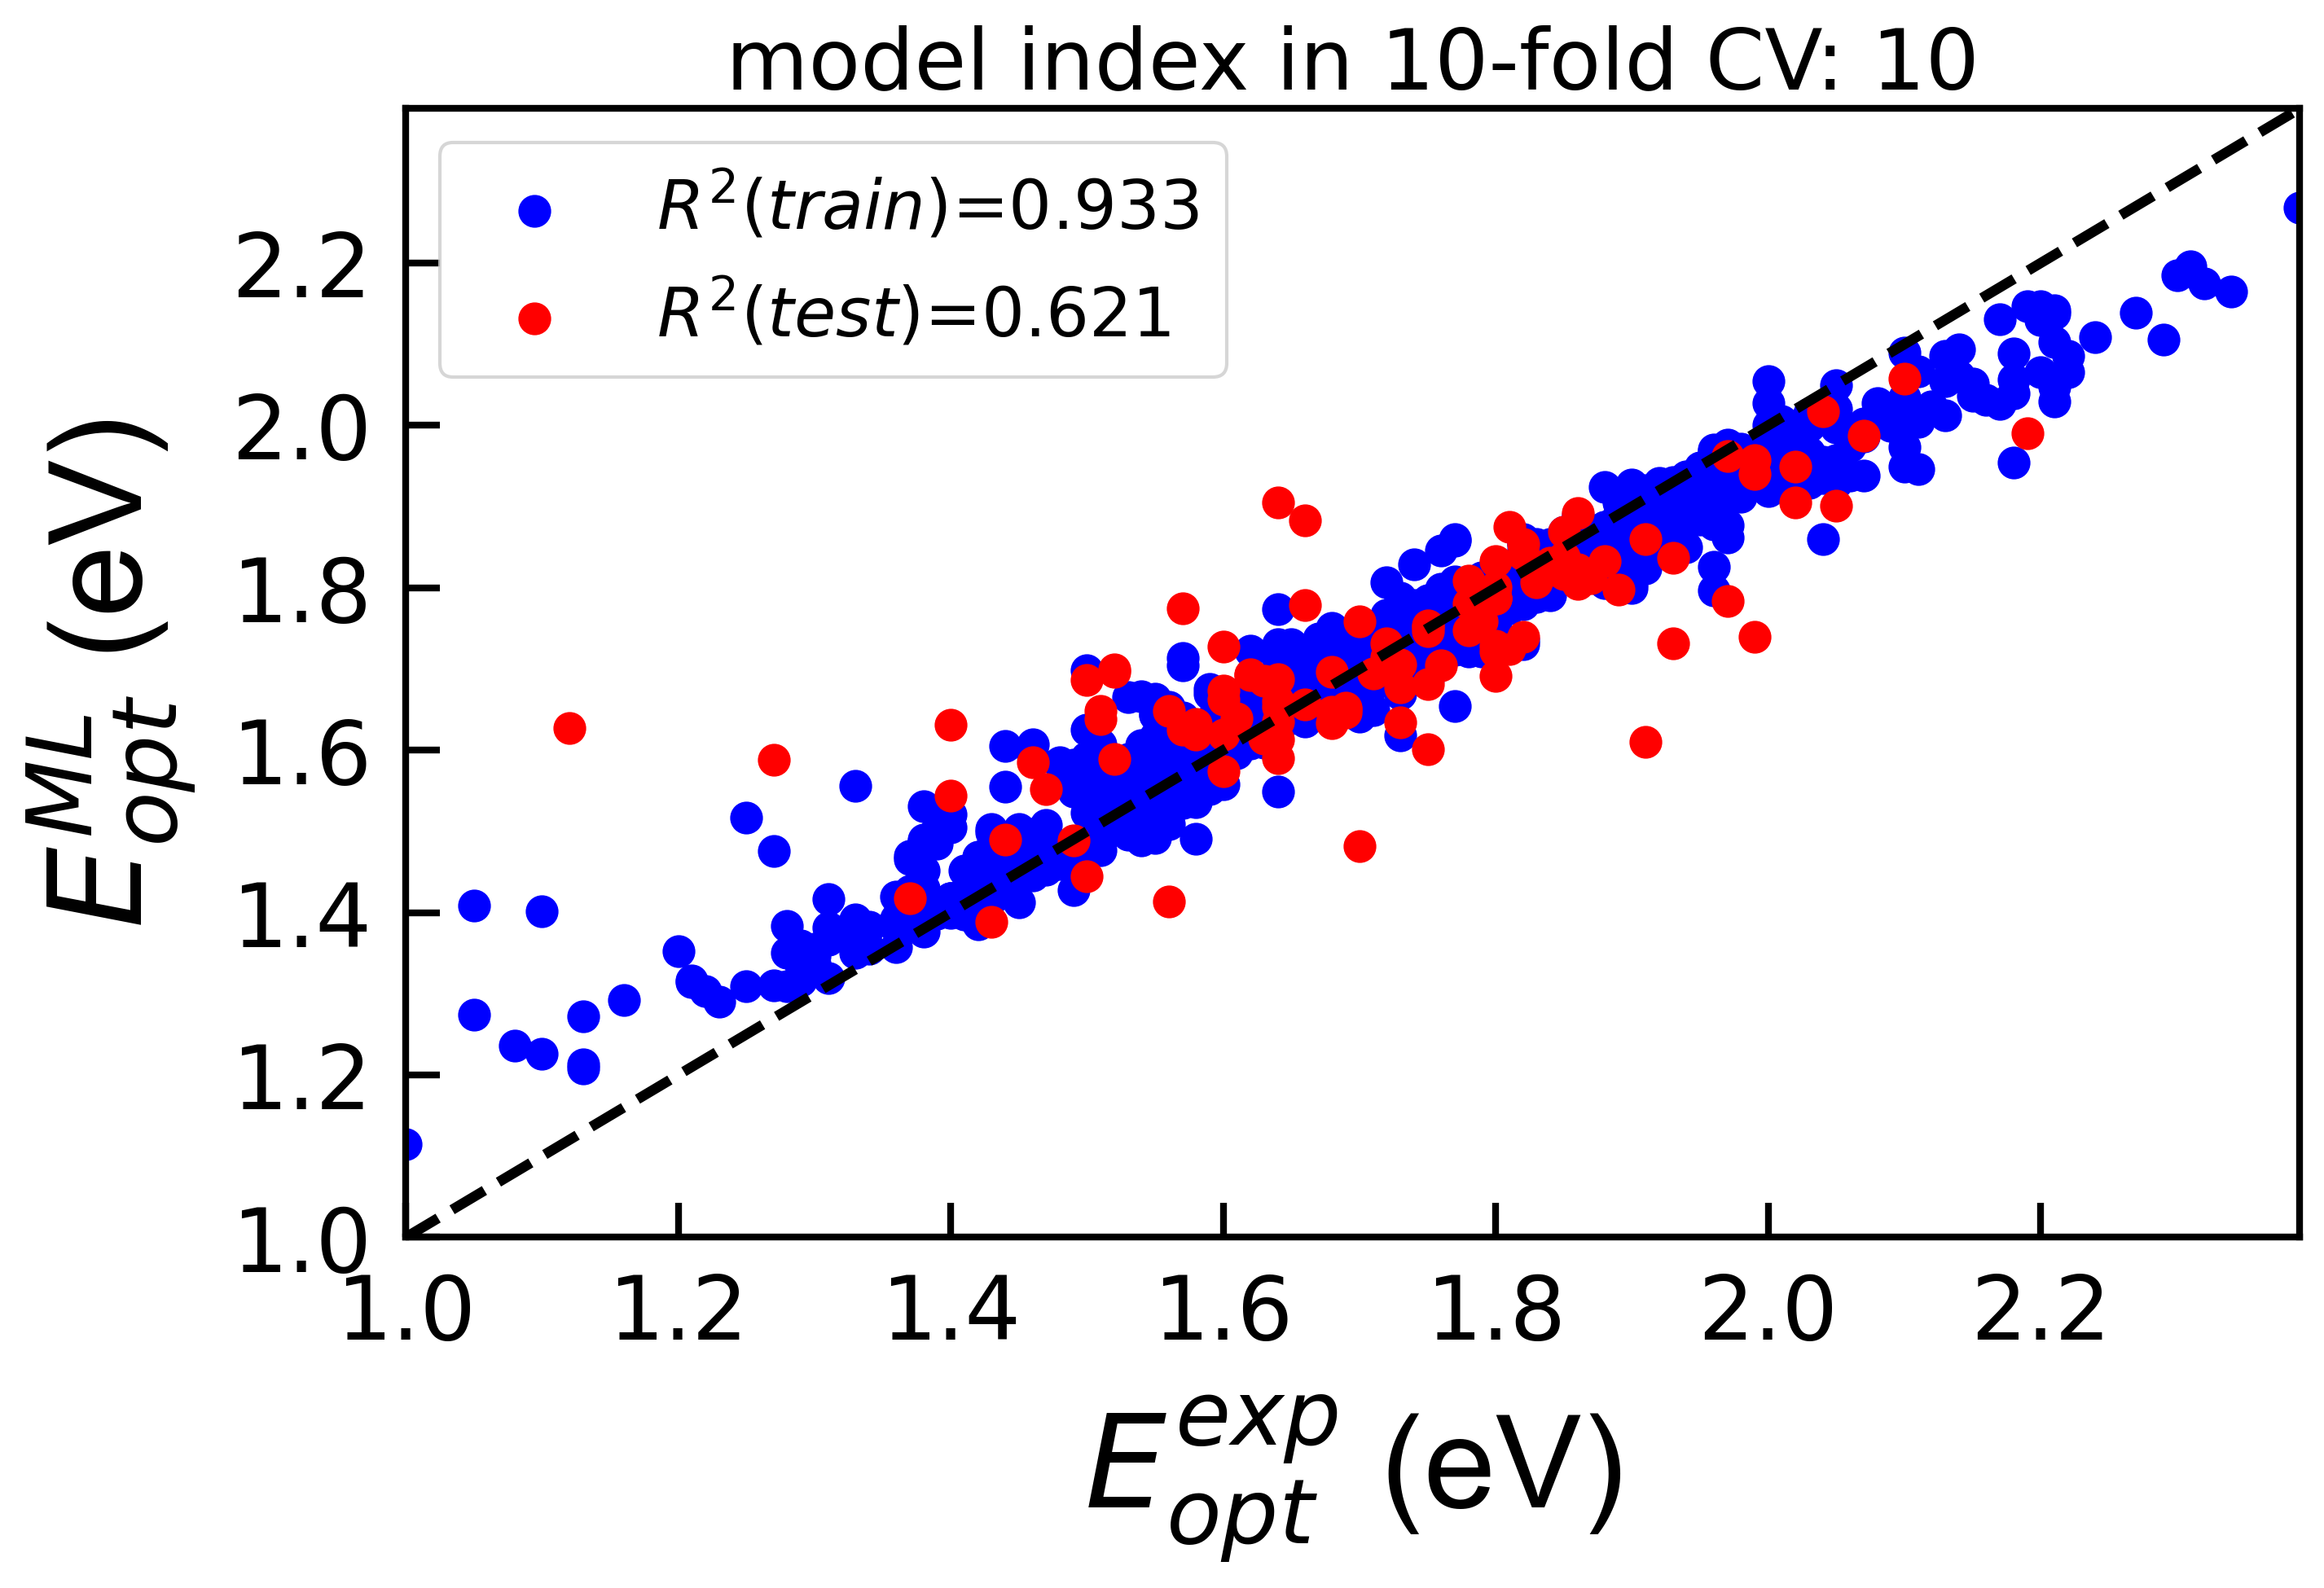

In [78]:
# 5fold-cv models

for i in range(xfold):
    train_index = train_idx_list[i]
    test_index = test_idx_list[i]
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    
    predictions_train = []
    predictions_test = []
    
    # 5fold-cv average for test set
    for j in range(xfold):
        model = models[i*xfold+j]     
               
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
              
        predictions_train.append(y_train_pred)
        predictions_test.append(y_test_pred)
    
    ## average R2 for train in each model
    df_train_pred = pd.DataFrame(predictions_train)
    df_train_pred = df_train_pred.T
    df_train_pred['mean'] = df_train_pred.iloc[:,:4].mean(axis = 1)
    r2_train = r2_score(y_train, df_train_pred['mean'])
    
    ## average R2 for test in each model
    df_test_pred = pd.DataFrame(predictions_test)
    df_test_pred = df_test_pred.T
    df_test_pred['mean'] = df_test_pred.iloc[:,:4].mean(axis = 1)
    r2_test = r2_score(y_test, df_test_pred['mean'])
    
    fold_idx=i+1
    parity_plot(y,y_train, y_test,df_train_pred['mean'], df_test_pred['mean'], r2_train, r2_test, fold_idx)
    

In [15]:
def mechine_regression(X_train,y_train, X_test, y_test):
    scores = []

    hgbr.fit(X_train, y_train)
    y_pred_test = hgbr.predict(X_test)
    RMSE_test, R2_test, r_test, MAE_test = acc(y_test,y_pred_test)
    type = 'hgbr'
    scores.append([type,RMSE_test, R2_test, r_test, MAE_test])

    lgbm.fit(X_train, y_train)
    y_pred_test = lgbm.predict(X_test)
    RMSE_test, R2_test, r_test, MAE_test = acc(y_test,y_pred_test)
    type = 'lgbm'
    scores.append([type,RMSE_test, R2_test, r_test, MAE_test])

    gbr.fit(X_train, y_train)
    y_pred_test = gbr.predict(X_test)
    RMSE_test, R2_test, r_test, MAE_test = acc(y_test,y_pred_test)
    type = 'gbr'
    scores.append([type,RMSE_test, R2_test, r_test, MAE_test])

    xgb.fit(X_train, y_train)
    y_pred_test = xgb.predict(X_test)
    RMSE_test, R2_test, r_test, MAE_test = acc(y_test,y_pred_test)
    type = 'xgb'
    scores.append([type,RMSE_test, R2_test, r_test, MAE_test])

    adaboost.fit(X_train, y_train)
    y_pred_test = adaboost.predict(X_test)
    RMSE_test, R2_test, r_test, MAE_test = acc(y_test,y_pred_test)
    type = 'adaboost'
    scores.append([type,RMSE_test, R2_test, r_test, MAE_test])

    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)
    RMSE_test, R2_test, r_test, MAE_test = acc(y_test,y_pred_test)
    type = 'rf'
    scores.append([type,RMSE_test, R2_test, r_test, MAE_test])
    
    scores_df = pd.DataFrame(scores, columns = ['model', 'R2', 'r', 'RMSE', 'MAE'])
    return scores_df

In [16]:
def ml_5fold(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # hgbr = HistGradientBoostingRegressor()
    # lgbm = LGBMRegressor(force_row_wise = True)
    # gbr = GradientBoostingRegressor()
    # xgb = XGBRegressor()
    # adaboost = AdaBoostRegressor()
    # rf = RandomForestRegressor()

    # rmse_df = mechine_regression(X_train_scaled, y_train, X_test_scaled, y_test)
    # rmse_df.round(3)

    ### 5fold cross validation

    # 初始化模型
    models = {
        'hgbr': HistGradientBoostingRegressor(),
        'lgbm': LGBMRegressor(force_col_wise=True, verbose=-1),
        'gbr': GradientBoostingRegressor(),
        'xgb': XGBRegressor(),
        'adaboost': AdaBoostRegressor(),
        'rf': RandomForestRegressor()
    }

    # 初始化5-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # 用于存储每个模型的R^2分数
    scores_dict = {name: [] for name in models.keys()}
    rmse_dict = {name: [] for name in models.keys()}

    # 对每个模型进行5-Fold CV
    for name, model in models.items():
        fold_preds = []  # 存储当前模型的所有预测结果
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # 训练模型
            model.fit(X_train_scaled, y_train)

            # 获取模型预测结果
            y_pred = model.predict(X_test_scaled)

            # 计算R^2分数并存储
            r2 = r2_score(y_test, y_pred)
            MSE = mean_squared_error(y_test,y_pred)
            RMSE = MSE ** 0.5
            scores_dict[name].append(r2)
            rmse_dict[name].append(RMSE)

    # 将R^2分数转换为Pandas DataFrame
    scores_df = pd.DataFrame(scores_dict)
    rmse_df = pd.DataFrame(rmse_dict)

    # 计算每个模型的平均R^2分数
    scores_df.loc['Mean'] = scores_df.mean()
    scores_df.loc['std'] = scores_df.std()
    rmse_df.loc['Mean'] = rmse_df.mean()
    rmse_df.loc['std'] = rmse_df.std()
    return scores_df.round(3), rmse_df.round(3)


In [17]:
df_exp = df_exp.reset_index(drop=True)
y = df_exp
y

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1083    1.68
1084    1.65
1085    1.66
1086    1.52
1087    1.73
Name: bandgap(eV), Length: 1088, dtype: float64

## RDKit+Morgan FP+MACCS

In [18]:
X0 = df_rdkit_screen
X1 = Morgan_fingerprints
X2 = MACCS_fingerprints
X3 = pd.concat([df_rdkit_screen, Morgan_fingerprints], axis = 1)
X4 = pd.concat([df_rdkit_screen, MACCS_fingerprints], axis = 1)
X5 = pd.concat([Morgan_fingerprints, MACCS_fingerprints], axis = 1)
X6 = pd.concat([df_rdkit_screen, Morgan_fingerprints, MACCS_fingerprints], axis = 1)

In [19]:
X_list = [X0, X1, X2, X3, X4, X5, X6]
X_label = [
          'rdkit',
          'Morgan',
          'MACCS',
          'rdkit+Morgan',
          'rdkit+MACCS',
          'Morgan+MACCS',
          'rdkit+Morgan+MACCS']

df_r2_mean=pd.DataFrame()
df_rmse_mean=pd.DataFrame()
for idx,X in zip(range(len(X_label)), X_list):
    print(X_label[idx])
    X = X.reset_index(drop=True)
    
    scores_df, rmse_df = ml_5fold(X,y)
    r2_row_to_add=scores_df.iloc[5:6]
    rmse_row_to_add=rmse_df.iloc[5:6]
    df_r2_mean=pd.concat([df_r2_mean, r2_row_to_add], axis = 0)
    df_rmse_mean=pd.concat([df_rmse_mean, rmse_row_to_add], axis = 0)


rdkit
Morgan
MACCS
rdkit+Morgan
rdkit+MACCS
Morgan+MACCS
rdkit+Morgan+MACCS


In [20]:
df_r2_mean.index = X_label
df_r2_mean.index.name = 'R2'

df_r2_mean

hgbr   lgbm    gbr    xgb  adaboost     rf
R2                                                             
rdkit               0.508  0.511  0.503  0.543     0.307  0.527
Morgan              0.663  0.657  0.590  0.660     0.371  0.633
MACCS               0.513  0.502  0.481  0.482     0.314  0.518
rdkit+Morgan        0.641  0.646  0.579  0.634     0.394  0.626
rdkit+MACCS         0.581  0.589  0.544  0.567     0.341  0.586
Morgan+MACCS        0.678  0.675  0.597  0.666     0.421  0.645
rdkit+Morgan+MACCS  0.655  0.657  0.595  0.637     0.417  0.646

In [21]:
df_rmse_mean.index = X_label
df_rmse_mean.index.name = 'RMSE(eV)'
df_rmse_mean

hgbr   lgbm    gbr    xgb  adaboost     rf
RMSE(eV)                                                       
rdkit               0.143  0.143  0.144  0.138     0.170  0.140
Morgan              0.118  0.119  0.130  0.118     0.162  0.123
MACCS               0.142  0.144  0.147  0.147     0.169  0.142
rdkit+Morgan        0.122  0.121  0.132  0.123     0.159  0.125
rdkit+MACCS         0.132  0.131  0.138  0.134     0.166  0.131
Morgan+MACCS        0.115  0.116  0.129  0.118     0.155  0.121
rdkit+Morgan+MACCS  0.120  0.119  0.130  0.122     0.156  0.121